Hello Fellow Kagglers,

This notebook demonstrates the feature engineering, training and inference process, all in one notebook!

Training takes ~2 hours and inference ~6, expect the submission to take roughly 8 hours.

A binary approach is used, as in many other notebooks, where, for a pair of points, a match confidence is predicted.

This notebook uses dataset generated in the follow notebooks:

1) [Foursquare 16M Train Pairs Generation](https://www.kaggle.com/code/markwijkhuizen/foursquare-16m-train-pairs-generation)
2) [Foursquare USE/MPNET Name Embeddings](https://www.kaggle.com/code/markwijkhuizen/foursquare-use-mpnet-name-embeddings)

Feel free to give tips and ask questions!

In [1]:
# Install Reverse Geocode Package to deduce Country/City from coordinates
!pip install /kaggle/input/reversegeocode/reverse_geocode-1.4.1-py3-none-any.whl

Processing /kaggle/input/reversegeocode/reverse_geocode-1.4.1-py3-none-any.whl


In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras import backend as K
from Levenshtein import distance as lev
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from sklearn import metrics
from multiprocessing import cpu_count
from sklearn.neighbors import BallTree
from difflib import SequenceMatcher

import geopy.distance
import reverse_geocode
import math
import scipy
import numba
import warnings
import Levenshtein
import itertools
import gc
import psutil
import sys
import pickle

# Pandas Apply With Progress Bar
tqdm.pandas()

# Plot DPI
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

# Tensorflow Version
print(f'Tensorflow version {tf.__version__}')

# Ignore Warnings
warnings.filterwarnings('ignore')

Tensorflow version 2.6.4


In [3]:
# Global Seed
SEED = 42
# Earth Radius in KM to compute Haversine Distance
EARTH_RADIUS = 6371

# Load Train/Test Data

In [4]:
usecols = [
    'id',
    'name',
    'latitude',
    'longitude',
    'address',
    'city',
    'state',
    'zip',
    'country',
    'url',
    'phone',
    'categories',
]

In [5]:
%%time
# Train
train_dtype = {
    'id': 'category',
    'name': 'category',
    'address': 'category',
    'city': 'category',
    'state': 'category',
    'zip': 'category',
    'country': 'category',
    'url': 'category',
    'phone': 'category',
    'categories': 'category',
    'latitude': np.float32,
    'longitude': np.float32,
}
train = pd.read_csv('/kaggle/input/foursquare-location-matching/train.csv', dtype=train_dtype, usecols=usecols)
train['id'] = train.index.values
display(train.info(memory_usage=True))
display(train.head())
display(train.memory_usage(deep=True) / len(train))

test = pd.read_csv('/kaggle/input/foursquare-location-matching/test.csv', dtype=train_dtype, usecols=usecols)
display(test.info())
display(test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138812 entries, 0 to 1138811
Data columns (total 12 columns):
 #   Column      Non-Null Count    Dtype   
---  ------      --------------    -----   
 0   id          1138812 non-null  int64   
 1   name        1138811 non-null  category
 2   latitude    1138812 non-null  float32 
 3   longitude   1138812 non-null  float32 
 4   address     742191 non-null   category
 5   city        839623 non-null   category
 6   state       718226 non-null   category
 7   zip         543386 non-null   category
 8   country     1138801 non-null  category
 9   url         267724 non-null   category
 10  phone       342855 non-null   category
 11  categories  1040505 non-null  category
dtypes: category(9), float32(2), int64(1)
memory usage: 135.2 MB


None

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories
0,0,Café Stad Oudenaarde,50.859974,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars
1,1,Carioca Manero,-22.907225,-43.178246,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants
2,2,ร้านตัดผมการาเกด,13.780813,100.484901,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops
3,3,Turkcell,37.844509,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops
4,4,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants


Index           0.000112
id              8.000000
name          106.860765
latitude        4.000000
longitude       4.000000
address        66.353886
city           10.581007
state           3.745623
zip            11.076517
country         2.018734
url            22.719279
phone          28.896098
categories     10.447042
dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          5 non-null      category
 1   name        5 non-null      category
 2   latitude    5 non-null      float32 
 3   longitude   5 non-null      float32 
 4   address     3 non-null      category
 5   city        3 non-null      category
 6   state       2 non-null      category
 7   zip         2 non-null      category
 8   country     5 non-null      category
 9   url         1 non-null      category
 10  phone       1 non-null      category
 11  categories  5 non-null      category
dtypes: category(10), float32(2)
memory usage: 1.4 KB


None

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories
0,E_00001118ad0191,Jamu Petani Bagan Serai,5.012169,100.535805,NaN,NaN,NaN,NaN,MY,NaN,NaN,Cafés
1,E_000020eb6fed40,Johnny's Bar,40.434208,-80.564163,497 N 12th St,Weirton,WV,26062,US,NaN,NaN,Bars
2,E_00002f98667edf,QIWI,47.215134,39.686089,"Межевая улица, 60",Ростов-на-Дону,NaN,NaN,RU,https://qiwi.com,+78003011131,ATMs
3,E_001b6bad66eb98,"Gelora Sriwijaya, Jaka Baring Sport City",-3.014675,104.794373,NaN,NaN,NaN,NaN,ID,NaN,NaN,Stadiums
4,E_0283d9f61e569d,Stadion Gelora Sriwijaya,-3.021727,104.788628,Jalan Gubernur Hasan Bastari,Palembang,South Sumatra,11480.0,ID,NaN,NaN,Soccer Stadiums


CPU times: user 23.4 s, sys: 805 ms, total: 24.2 s
Wall time: 28.4 s


# Load Pairs

In [6]:
# Pairs Datype
pairs_dtype = {
    'id_1': 'category',
    'id_2': 'category',
    'name_1': 'category',
    'name_2': 'category',
    'address_1': 'category',
    'address_1': 'category',
    'city_1': 'category',
    'city_2': 'category',
    'state_1': 'category',
    'state_2': 'category',
    'zip_1': 'category',
    'zip_2': 'category',
    'country_1': 'category',
    'country_2': 'category',
    'url_1': 'category',
    'url_2': 'category',
    'phone_1': 'category',
    'phone_2': 'category',
    'categories_1': 'category',
    'categories_2': 'category',
    'latitude_1': np.float32,
    'longitude_1': np.float32,
    'latitude_2': np.float32,
    'longitude_2': np.float32,
}
pd.options.display.max_rows = 99
pd.options.display.max_columns = 99

pairs_sample = pd.read_csv('/kaggle/input/foursquare-location-matching/pairs.csv', dtype=pairs_dtype, skiprows=lambda idx: idx > 5)
display(pairs_sample.info())
display(pairs_sample.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id_1          5 non-null      category
 1   name_1        5 non-null      category
 2   latitude_1    5 non-null      float32 
 3   longitude_1   5 non-null      float32 
 4   address_1     5 non-null      category
 5   city_1        4 non-null      category
 6   state_1       4 non-null      category
 7   zip_1         3 non-null      category
 8   country_1     5 non-null      category
 9   url_1         1 non-null      category
 10  phone_1       1 non-null      category
 11  categories_1  5 non-null      category
 12  id_2          5 non-null      category
 13  name_2        5 non-null      category
 14  latitude_2    5 non-null      float32 
 15  longitude_2   5 non-null      float32 
 16  address_2     2 non-null      object  
 17  city_2        3 non-null      category
 18  state_2       

None

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,phone_1,categories_1,id_2,name_2,latitude_2,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859974,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,E_da7fa3963561f8,Café Oudenaarde,50.869358,3.635206,NaN,NaN,NaN,NaN,BE,NaN,NaN,Bars,True
1,E_000008a8ba4f48,Turkcell,37.844509,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,E_3f12df0b045062,Turkcell,37.838020,27.845560,batı aydın,aydın,NaN,67500,TR,NaN,NaN,Electronics Stores,False
2,E_000023d8f4be44,Island Spa,14.518970,121.018700,"5th Flr, Newport Mall, Resorts World Manila",Pasay City,Metro Manila,NaN,PH,NaN,NaN,Spas,E_12453effe251db,Island Spa Theater,14.518330,121.019829,NaN,NaN,NaN,NaN,PH,NaN,NaN,Spas,True
3,E_00007dcd2bb53f,TOGO'S Sandwiches,38.257797,-122.064598,"1380 Holiday Ln., Ste. B",Fairfield,CA,94534,US,https://locations.togos.com/ll/US/CA/Fairfield...,7074394747,Sandwich Places,E_f131dcb7f07be9,Togo's,38.257938,-122.064606,NaN,Fairfield,CA,NaN,US,NaN,NaN,Sandwich Places,True
4,E_0000c362229d93,Coffee Cat,7.082218,125.610245,F. Torres St.,Davao City,Davao Region,8000,PH,NaN,NaN,"Cafés, Coffee Shops",E_d52c3c4d53831c,Coffeecat,7.076016,125.611458,E. Jacinto Extension,Davao City,Davao Region,8000,PH,NaN,NaN,"Coffee Shops, Cafés, Dessert Shops",False


# Load Sample Submission

In [7]:
# Sample Submission
sample_submission = pd.read_csv('/kaggle/input/foursquare-location-matching/sample_submission.csv')
display(sample_submission.info())
display(sample_submission.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       5 non-null      object
 1   matches  5 non-null      object
dtypes: object(2)
memory usage: 208.0+ bytes


None

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98


# To Lower

In [8]:
# Convert String columns to lower case to make features case agnostic
to_lower_columns = [
    'name',
    'state',
    'country',
    'city',
    'address',
    'zip',
    'phone',
    'url',
    'categories',
]

def to_lower(df):
    f = lambda v: '' if v == 'NaN' else v.lower()
    for col in to_lower_columns:
        if f'{col}_1' in df and f'{col}_2' in df:
            df[f'{col}_1'] = df[f'{col}_1'].astype(str, copy=False).str.lower().replace('nan', '').astype('category')
            df[f'{col}_2'] = df[f'{col}_2'].astype(str, copy=False).str.lower().replace('nan', '').astype('category')
        else:
            df[col] = df[col].astype(str, copy=False).str.lower().replace('nan', '').astype('category')
            
to_lower(train)
to_lower(pairs_sample)
to_lower(test)

In [9]:
display(train.head())

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories
0,0,café stad oudenaarde,50.859974,3.634196,abdijstraat,nederename,oost-vlaanderen,9700,be,,,bars
1,1,carioca manero,-22.907225,-43.178246,,,,,br,,,brazilian restaurants
2,2,ร้านตัดผมการาเกด,13.780813,100.484901,,,,,th,,,salons / barbershops
3,3,turkcell,37.844509,27.844202,adnan menderes bulvarı,,,,tr,,,mobile phone shops
4,4,restaurante casa cofiño,43.338196,-4.326821,,caviedes,cantabria,,es,,,spanish restaurants


In [10]:
display(pairs_sample.head())

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,phone_1,categories_1,id_2,name_2,latitude_2,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match
0,E_000001272c6c5d,café stad oudenaarde,50.859974,3.634196,abdijstraat,nederename,oost-vlaanderen,9700,be,,,bars,E_da7fa3963561f8,café oudenaarde,50.869358,3.635206,,,,,be,,,bars,True
1,E_000008a8ba4f48,turkcell,37.844509,27.844202,adnan menderes bulvarı,,,,tr,,,mobile phone shops,E_3f12df0b045062,turkcell,37.838020,27.845560,batı aydın,aydın,,67500,tr,,,electronics stores,False
2,E_000023d8f4be44,island spa,14.518970,121.018700,"5th flr, newport mall, resorts world manila",pasay city,metro manila,,ph,,,spas,E_12453effe251db,island spa theater,14.518330,121.019829,,,,,ph,,,spas,True
3,E_00007dcd2bb53f,togo's sandwiches,38.257797,-122.064598,"1380 holiday ln., ste. b",fairfield,ca,94534,us,https://locations.togos.com/ll/us/ca/fairfield...,7074394747,sandwich places,E_f131dcb7f07be9,togo's,38.257938,-122.064606,,fairfield,ca,,us,,,sandwich places,True
4,E_0000c362229d93,coffee cat,7.082218,125.610245,f. torres st.,davao city,davao region,8000,ph,,,"cafés, coffee shops",E_d52c3c4d53831c,coffeecat,7.076016,125.611458,e. jacinto extension,davao city,davao region,8000,ph,,,"coffee shops, cafés, dessert shops",False


In [11]:
display(test.head())

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories
0,E_00001118ad0191,jamu petani bagan serai,5.012169,100.535805,,,,,my,,,cafés
1,E_000020eb6fed40,johnny's bar,40.434208,-80.564163,497 n 12th st,weirton,wv,26062,us,,,bars
2,E_00002f98667edf,qiwi,47.215134,39.686089,"межевая улица, 60",ростов-на-дону,,,ru,https://qiwi.com,+78003011131,atms
3,E_001b6bad66eb98,"gelora sriwijaya, jaka baring sport city",-3.014675,104.794373,,,,,id,,,stadiums
4,E_0283d9f61e569d,stadion gelora sriwijaya,-3.021727,104.788628,jalan gubernur hasan bastari,palembang,south sumatra,11480.0,id,,,soccer stadiums


In [12]:
# Load Pairs generated in other notebook
pairs = pd.read_pickle('/kaggle/input/foursquare-16m-train-pairs-generation-dataset/pairs.pkl')

# Display Memory Usage
display(pairs.memory_usage(deep=True) / len(pairs))

# Display Pairs Data
display(pairs.head(25))
display(pairs.info())

# Display Positive/Negative Sample Ratio's
display(pairs['match'].value_counts(normalize=True).to_frame())

# Unique Names
display(pairs[['name_1', 'name_2']].nunique())

Index           0.000008
match           1.000000
id_1            9.056475
id_2            9.056475
name_1          8.430369
name_2          8.430369
latitude_1      4.000000
latitude_2      4.000000
longitude_1     4.000000
longitude_2     4.000000
address_1       6.945720
address_2       6.945720
city_1          4.287687
city_2          4.287687
state_1         2.071253
state_2         2.071253
zip_1           4.361293
zip_2           4.361293
country_1       2.000797
country_2       2.000797
url_1           5.038766
url_2           5.038766
phone_1         5.211672
phone_2         5.211672
categories_1    4.311623
categories_2    4.311623
dtype: float64

,match,id_1,id_2,name_1,name_2,latitude_1,latitude_2,longitude_1,longitude_2,address_1,address_2,city_1,city_2,state_1,state_2,zip_1,zip_2,country_1,country_2,url_1,url_2,phone_1,phone_2,categories_1,categories_2
0,False,E_b4a705f3f2e85e,E_ce077098a7cf4f,pabellon t sala 6,5°a,-23.677120,-23.677223,-70.409782,-70.410149,,british school,,antofagasta,,región de antofagasta,,,cl,cl,,,,,universities,college classrooms
1,False,E_ce077098a7cf4f,E_b4a705f3f2e85e,5°a,pabellon t sala 6,-23.677223,-23.677120,-70.410149,-70.409782,british school,,antofagasta,,región de antofagasta,,,,cl,cl,,,,,college classrooms,universities
2,False,E_b4a705f3f2e85e,E_683c38e096a091,pabellon t sala 6,the antofagasta british school,-23.677120,-23.676983,-70.409782,-70.410179,,pedro león gallo 723,,antofagasta,,región de antofagasta,,,cl,cl,,http://www.colegio-abs.cl,,55598930,universities,"schools, college soccer fields"
3,False,E_683c38e096a091,E_b4a705f3f2e85e,the antofagasta british school,pabellon t sala 6,-23.676983,-23.677120,-70.410179,-70.409782,pedro león gallo 723,,antofagasta,,región de antofagasta,,,,cl,cl,http://www.colegio-abs.cl,,55598930,,"schools, college soccer fields",universities
4,False,E_b4a705f3f2e85e,E_40b7276a8f110c,pabellon t sala 6,5°b,-23.677120,-23.677315,-70.409782,-70.410202,,british school,,antofagasta,,región de antofagasta,,,cl,cl,,,,,universities,college classrooms
5,False,E_40b7276a8f110c,E_b4a705f3f2e85e,5°b,pabellon t sala 6,-23.677315,-23.677120,-70.410202,-70.409782,british school,,antofagasta,,región de antofagasta,,,,cl,cl,,,,,college classrooms,universities
6,False,E_b4a705f3f2e85e,E_cc4c949a63a9cd,pabellon t sala 6,sala de computación abs,-23.677120,-23.676867,-70.409782,-70.410393,,,,,,,,,cl,cl,,,,,universities,college classrooms
7,False,E_cc4c949a63a9cd,E_b4a705f3f2e85e,sala de computación abs,pabellon t sala 6,-23.676867,-23.677120,-70.410393,-70.409782,,,,,,,,,cl,cl,,,,,college classrooms,universities
8,False,E_b4a705f3f2e85e,E_6d5c514733426c,pabellon t sala 6,parroquia madre de dios,-23.677120,-23.677984,-70.409782,-70.409523,,avda. angamos 0535,,antofagasta,,región de antofagasta,,,cl,cl,,,,,universities,churches
9,False,E_6d5c514733426c,E_b4a705f3f2e85e,parroquia madre de dios,pabellon t sala 6,-23.677984,-23.677120,-70.409523,-70.409782,avda. angamos 0535,,antofagasta,,región de antofagasta,,,,cl,cl,,,,,churches,universities


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16421668 entries, 0 to 16421667
Data columns (total 25 columns):
 #   Column        Dtype   
---  ------        -----   
 0   match         bool    
 1   id_1          category
 2   id_2          category
 3   name_1        category
 4   name_2        category
 5   latitude_1    float32 
 6   latitude_2    float32 
 7   longitude_1   float32 
 8   longitude_2   float32 
 9   address_1     category
 10  address_2     category
 11  city_1        category
 12  city_2        category
 13  state_1       category
 14  state_2       category
 15  zip_1         category
 16  zip_2         category
 17  country_1     category
 18  country_2     category
 19  url_1         category
 20  url_2         category
 21  phone_1       category
 22  phone_2       category
 23  categories_1  category
 24  categories_2  category
dtypes: bool(1), category(20), float32(4)
memory usage: 1.4 GB


None

,match
False,0.884238
True,0.115762


name_1    816209
name_2    816209
dtype: int64

# Train Explorative Data Analysis

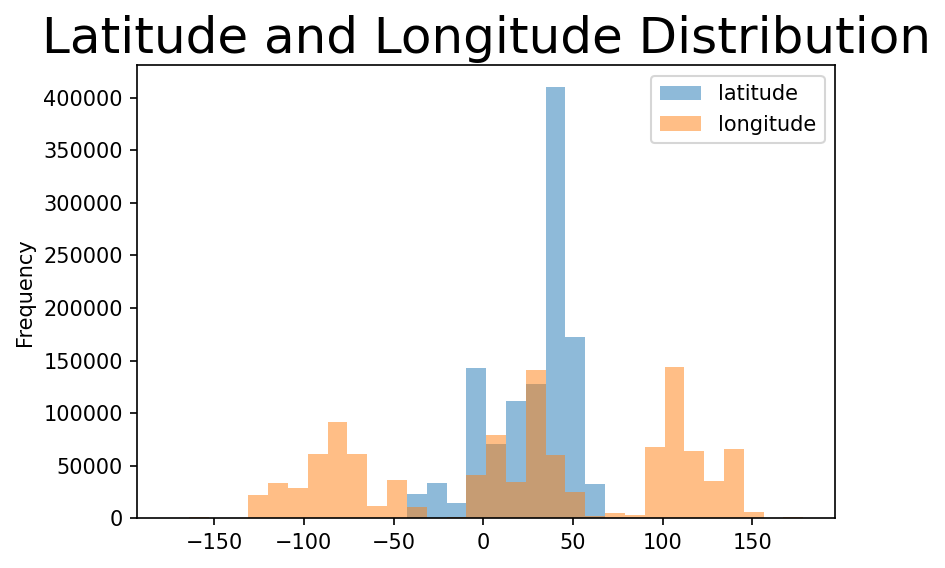

In [13]:
# Latitude
train[['latitude', 'longitude']].plot(kind='hist', bins=32, alpha=0.50)
plt.title('Latitude and Longitude Distribution', size=24)
plt.show()

In [14]:
# Most common names are fast food restaurants
print(f'Unique Names in Train: {train["name"].nunique()}\n')
print('===== Top 10 Most Occuring Names =====')
display(train['name'].value_counts(dropna=False, normalize=True).head(10))

Unique Names in Train: 817309

===== Top 10 Most Occuring Names =====


starbucks             0.005003
mcdonald's            0.003026
redbox                0.002808
subway                0.002441
7-eleven              0.001788
payless shoesource    0.001719
kfc                   0.001581
burger king           0.001323
shell                 0.001149
pizza hut             0.000947
Name: name, dtype: float64

In [15]:
# Cities are really all over the world and, most importantly, sometimes spelled in their native language
# санкт-петербург: Saint Petersburg
print(f'Unique Cities in Train: {train["city"].nunique()}\n')
print('===== Top 10 Most Occuring Cities =====')
display(train['city'].value_counts(dropna=False).head(10))

Unique Cities in Train: 62640

===== Top 10 Most Occuring Cities =====


                   299198
singapore           10329
москва               9685
bandung              9006
new york             8698
i̇stanbul            6884
санкт-петербург      6326
kuala lumpur         5556
são paulo            5288
ankara               4230
Name: city, dtype: int64

In [16]:
# 420K states are empty
print(f'Unique States in Train: {train["state"].nunique()}\n')
print('===== Top 10 Most Occuring States =====')
display(train['state'].value_counts(dropna=False).head(10))

Unique States in Train: 14893

===== Top 10 Most Occuring States =====


           420612
ca          28909
ny          21796
fl          17248
tx          17029
東京都         15868
bangkok     11832
pa          10556
il           9895
mi           8100
Name: state, dtype: int64

In [17]:
# Over half of the zip codes are missing
print(f'Unique Zip Codes in Train: {train["zip"].nunique()}\n')
print('===== Top 10 Most Occuring Zip Codes =====')
display(train['zip'].value_counts(dropna=False).head(10))

Unique Zip Codes in Train: 93219

===== Top 10 Most Occuring Zip Codes =====


         595426
9000       1885
10330      1417
10110      1235
10400      1184
2000       1181
1000       1005
3000        903
11000       876
10900       840
Name: zip, dtype: int64

In [18]:
# Close to a quarter of the point are located in the US
print(f'Unique States in Countries: {train["country"].nunique()}\n')
print('===== Top 10 Most Occuring Countries =====')
display(train['country'].value_counts(dropna=False).head(10))

Unique States in Countries: 222

===== Top 10 Most Occuring Countries =====


us    245284
tr    115177
id    110796
jp     70032
th     58808
ru     57030
br     51241
my     46326
be     25821
gb     25544
Name: country, dtype: int64

In [19]:
# URLS are rare, over 75% is missing
print(f'Unique URLs in Train: {train["url"].nunique()}\n')
print('===== Top 10 Most Occuring URLs =====')
display(train['url'].value_counts(dropna=False).head(10))

Unique URLs in Train: 171149

===== Top 10 Most Occuring URLs =====


                                871088
https://www.sej.co.jp              921
http://www.7eleven.co.th           833
http://www.payless.com/            687
https://www.dunkindonuts.com       643
https://www.family.co.jp           611
http://www.redbox.com              601
http://www.sberbank.ru             587
http://www.starbucks.com/          444
http://www.isbank.com.tr           427
Name: url, dtype: int64

In [20]:
# Phone is also missing in ~75% of the cases, not a good feature
print(f'Unique Phone Numbers in Train: {train["phone"].nunique()}\n')
print('===== Top 10 Most Occuring Phone Numbers =====')
display(train['phone'].value_counts(dropna=False).head(10))

Unique Phone Numbers in Train: 293455

===== Top 10 Most Occuring Phone Numbers =====


                  795957
8667332693          1875
+18667332693        1010
+18002758777         559
+498002000015        365
+4922120199959       363
820820001            313
+3270220200          263
+864008206998        219
+33149461720         195
Name: phone, dtype: int64

In [21]:
# Categories are varying from cafes and hotel to offices and banks
print(f'Unique Categories in Train: {train["categories"].nunique()}\n')
print('===== Top 10 Most Occuring Categories =====')
display(train['categories'].value_counts(dropna=False).head(10))

Unique Categories in Train: 52579

===== Top 10 Most Occuring Categories =====


                                               98307
residential buildings (apartments / condos)    25481
banks                                          21494
college classrooms                             21438
cafés                                          17805
coffee shops                                   17097
offices                                        16954
hotels                                         16583
convenience stores                             13530
buildings                                      11981
Name: categories, dtype: int64

# Haversine Distance

In [22]:
# Numba optimized haversine distance
@numba.jit(nopython=True)
def haversine_np(args):
    lon1, lat1, lon2, lat2 = args
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = EARTH_RADIUS * c
    return km

# Country Code

[Reverse Geocode](https://pypi.org/project/reverse-geocode/) package is used to deduce missing country and city based on coordinates

In [23]:
def get_country_codes(coords):
    data = reverse_geocode.search(coords)
    return [v['country_code'] for v in data]

train['country_code'] = get_country_codes(train[['latitude', 'longitude']])

pairs['country_code_1'] = get_country_codes(pairs[['latitude_1', 'longitude_1']])
pairs['country_code_2'] = get_country_codes(pairs[['latitude_2', 'longitude_2']])

print(f'Unique Country Code 1 in Pairs: {pairs["country_code_1"].nunique()}\n')
print('===== Top 10 Most Occuring Country Codes 1 =====')
display(pairs['country_code_1'].value_counts(dropna=False).head(10))

Unique Country Code 1 in Pairs: 214

===== Top 10 Most Occuring Country Codes 1 =====


US    3279667
ID    1910615
TR    1746509
JP     971046
RU     832750
TH     817832
MY     799785
BR     756189
GB     367208
BE     362314
Name: country_code_1, dtype: int64

# City

In [24]:
def get_cities(coords):
    data = reverse_geocode.search(coords)
    return [v['city'] for v in data]

train['city_rg'] = get_cities(train[['latitude', 'longitude']])
    
pairs['city_rg_1'] = get_cities(pairs[['latitude_1', 'longitude_1']])
pairs['city_rg_2'] = get_cities(pairs[['latitude_2', 'longitude_2']])

print(f'Unique City Reverse Geocode 1 in Pairs: {pairs["city_rg_1"].nunique()}\n')
print('===== Top 10 Most Occuring City Reverse Geocode 1 =====')
display(pairs['city_rg_1'].value_counts(dropna=False).head(10))

Unique City Reverse Geocode 1 in Pairs: 34749

===== Top 10 Most Occuring City Reverse Geocode 1 =====


Jakarta          358493
Singapore        252515
Tokyo            209861
Bandung          207873
Kuala Lumpur     162855
Gramercy Park    100594
São Paulo         83005
Şişli             74041
Yongsan-dong      71270
Johor Bahru       70165
Name: city_rg_1, dtype: int64

# Make Ordinal Encoding

To prevent overfitting on categorical columns the ordinal encoding takes the N most common categories and puts all other categories in an "others" category. Otherwise there would be many categories with just a handfull of samples, which almost guarantees overfitting.

In [25]:
columns_ordinal = [
    'name',
    'state',
    'country',
    'country_code',
    'city',
    'city_rg',
    'address',
    'zip',
    'url',
]

cat2ord_dict_dicts = dict()
TOP_K = {
    'name': 2048,
    'state': 2048,
    'country': 1024,
    'country_code': 1024,
    'city': 2048,
    'city_rg': 1024,
    'address': 1024,
    'zip': 1024,
    'phone': 1024,
    'url': 1024,
}
for col in tqdm(columns_ordinal):
    n_categories = train[col].nunique()
    cat_codes = train[col].astype('category').cat.codes
    if n_categories < TOP_K[col]:
        train[f'{col}_ordinal'] = cat_codes
    else:
        # Ordinal Encoding + 1 for "Others" category
        train[f'{col}_ordinal'] = cat_codes + 1
    
        # Category Population Count
        train[f'{col}_count'] = train[col].apply(train[col].value_counts().get).astype(np.float32)
        # Set all categories with less than top 1000 population count to 0 "Others" category
        top_k_count = train[col].value_counts()[TOP_K[col] - 1 if cat_codes.max() >= TOP_K[col] else -1]
        train.loc[train[f'{col}_count'] <= top_k_count, f'{col}_ordinal'] = 0
        train[f'{col}_ordinal'] = train[f'{col}_ordinal'].astype('category').cat.codes
    
    # Make Cateogry to Ordinal Dictionary
    cat2ord_dict_dicts[col] = train[[col, f'{col}_ordinal']].set_index(col).squeeze().to_dict()
    n_unique = train[f'{col}_ordinal'].nunique()
    cat2ord_dict_dicts[f'{col}_count'] = n_unique
    print(f'{col} has {n_unique} categories, max: {train[col].nunique()}')

  0%|          | 0/9 [00:00<?, ?it/s]

name has 1995 categories, max: 817309
state has 1985 categories, max: 14893
country has 222 categories, max: 222
country_code has 217 categories, max: 217
city has 2025 categories, max: 62640
city_rg has 1018 categories, max: 35541
address has 927 categories, max: 548644
zip has 1011 categories, max: 93219
url has 1023 categories, max: 171149


In [26]:
# Adds ordinal features
def add_ordinal_features(df):
    for col in tqdm(columns_ordinal):
        df[f'{col}_1_ordinal'] = df[f'{col}_1'].apply(cat2ord_dict_dicts[col].get).astype(np.float32, copy=False).fillna(-1).astype(np.int16, copy=False) + 1
        df[f'{col}_2_ordinal'] = df[f'{col}_2'].apply(cat2ord_dict_dicts[col].get).astype(np.float32, copy=False).fillna(-1).astype(np.int16, copy=False) + 1

# Split Categories And Ordinal Encode

In [27]:
# Set with all unique categories
CATEGORIES = set()

for cats in tqdm(train['categories'].str.split(', ')):
    if type(cats) is list:
        for c in cats:
                CATEGORIES.add(c)

CATEGORIES_LIST_VALID = np.array(list(CATEGORIES))
# Add the empty category, as some categories are missing
CATEGORIES_LIST = np.sort(['AAA_empty'] + list(CATEGORIES)).tolist()
CATEGORIES = pd.Series(index=CATEGORIES_LIST, data=np.arange(len(CATEGORIES_LIST)))
# Number of Categories, "+1" for NaN
N_CATEGORIES = CATEGORIES.size + 1
N_CATEGORIES_VALID = CATEGORIES_LIST_VALID.size
CAT2ORD_DICT = CATEGORIES.to_dict()
print(f'N_CATEGORIES: {N_CATEGORIES}, N_CATEGORIES_VALID: {N_CATEGORIES_VALID}')

  0%|          | 0/1138812 [00:00<?, ?it/s]

N_CATEGORIES: 913, N_CATEGORIES_VALID: 911


In [28]:
def add_categories_features(df):
    def get_categories_ordinal(categories, idx):
        # For missing categories, return 0
        if type(categories) is not str:
            return 0
        else:
            # Split categories on comma
            l = np.sort(categories.split(', '))
            # If index of category is larger than number of categories, return 0
            if idx >= len(l):
                return 0
            else:
                # Check if category is in categories dictionary, to prevent keyerror for new categories
                if l[idx] in CAT2ORD_DICT:
                    return CAT2ORD_DICT.get(l[idx]) + 1
                # if category is unknown, return 0
                else:
                    return 0

    # Ordinal encode first 3 categories
    for i in tqdm(range(3)):
        df[f'categories{i}_1_ordinal'] = df[f'categories_1'].apply(get_categories_ordinal, idx=i).astype(np.int16)
        df[f'categories{i}_2_ordinal'] = df[f'categories_2'].apply(get_categories_ordinal, idx=i).astype(np.int16)

In [29]:
# Stand alone features are computed for a single point and not as relation between pairs
def add_stand_alone_features(df):
    print('===== Ordinal Features =====')
    add_ordinal_features(df)
    add_categories_features(df)
    
# Add all features to the pairs DataFrame
add_stand_alone_features(pairs)

===== Ordinal Features =====


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
# Show NaN ratio's for categories
for i in range(3):
    nan_ratio_1 = np.mean(pairs[f'categories{i}_1_ordinal'] == 0) * 100
    nan_ratio_2 = np.mean(pairs[f'categories{i}_2_ordinal'] == 0) * 100
    print(f'{i} | NaN ratio 1: {nan_ratio_1:.1f}%, NaN ratio 2: {nan_ratio_2:.1f}%')

0 | NaN ratio 1: 0.0%, NaN ratio 2: 0.0%
1 | NaN ratio 1: 83.2%, NaN ratio 2: 83.2%
2 | NaN ratio 1: 95.2%, NaN ratio 2: 95.2%


# Category Embedding

In [31]:
# Universal Sentence Encoder for English words used to embed categories
def get_categories_embedding():
    embed = hub.load('/kaggle/input/universalsentenceencoderlarge/universal-sentence-encoder-large_5')
    
    EMBEDDING_SIZE = 512
    CATEGORIES_EMBEDDING = np.zeros(shape=[N_CATEGORIES_VALID, EMBEDDING_SIZE], dtype=np.float32)

    for cat_idx, cat in enumerate(tqdm(CATEGORIES_LIST_VALID)):
        CATEGORIES_EMBEDDING[cat_idx] = embed([cat])
        
    return CATEGORIES_EMBEDDING

In [32]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [33]:
# Embeddings of Categories
CATEGORIES_EMBEDDING = get_categories_embedding()

# Create Cosine Similarity Matrix
EMBEDDING_DISTANCE = np.full(shape=[N_CATEGORIES, N_CATEGORIES], fill_value=np.nan, dtype=np.float32)
for idx_a, cat_emb_a in enumerate(tqdm(CATEGORIES_EMBEDDING)):
    for idx_b, cat_emb_b in enumerate(CATEGORIES_EMBEDDING):
        EMBEDDING_DISTANCE[idx_a + 2, idx_b + 2] = cosine_similarity(cat_emb_a, cat_emb_b)
        
# Always Save Embedding Distances for Next Time
print(f'EMBEDDING_DISTANCE shape: {EMBEDDING_DISTANCE.shape}, EMBEDDING_DISTANCE dtype: {EMBEDDING_DISTANCE.dtype}')
np.save('EMBEDDING_DISTANCE.npy', EMBEDDING_DISTANCE)

2022-06-10 12:42:05.998167: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-06-10 12:42:22.568863: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


  0%|          | 0/911 [00:00<?, ?it/s]

  0%|          | 0/911 [00:00<?, ?it/s]

EMBEDDING_DISTANCE shape: (913, 913), EMBEDDING_DISTANCE dtype: float32


In [34]:
# Sanity check for embedding distances
display(pd.Series(EMBEDDING_DISTANCE.flatten()).describe().to_frame(name='Value'))

,Value
count,829921.000000
mean,0.264489
std,0.119875
min,-0.180754
25%,0.185231
50%,0.245945
75%,0.319275
max,1.000000


In [35]:
# Adds distance between a category and the most similar category of the other point
def add_categories_distance_features(df):
    for i in range(3):
        df[f'categories{i}_distance'] = np.nanmax(
            np.stack((
                EMBEDDING_DISTANCE[df[f'categories{i}_1_ordinal'].astype(np.int32), df[f'categories0_2_ordinal'].astype(np.int32)],
                EMBEDDING_DISTANCE[df[f'categories{i}_1_ordinal'].astype(np.int32), df[f'categories1_2_ordinal'].astype(np.int32)],
                EMBEDDING_DISTANCE[df[f'categories{i}_1_ordinal'].astype(np.int32), df[f'categories2_2_ordinal'].astype(np.int32)],
            ))
        , axis=0)

# Name Embedding

Embeddings are used from the [Foursquare USE/MPNET Name Embeddings](https://www.kaggle.com/code/markwijkhuizen/foursquare-use-mpnet-name-embeddings/notebook) notebook

In [36]:
NAMES_EMBEDDINGS_USE = np.load('/kaggle/input/foursquare-usempnet-name-embeddings-dataset/NAMES_EMBEDDINGS_USE.npy')
NAMES_EMBEDDINGS_MPNET = np.load('/kaggle/input/foursquare-usempnet-name-embeddings-dataset/NAMES_EMBEDDINGS_MPNET.npy')

print(f'NAMES_EMBEDDINGS_USE shape: {NAMES_EMBEDDINGS_USE.shape}, dtype: {NAMES_EMBEDDINGS_USE.dtype}')
print(f'NAMES_EMBEDDINGS_MPNET shape: {NAMES_EMBEDDINGS_MPNET.shape}, dtype: {NAMES_EMBEDDINGS_MPNET.dtype}')

NAMES_EMBEDDINGS_USE shape: (817309, 512), dtype: float32
NAMES_EMBEDDINGS_MPNET shape: (817309, 768), dtype: float32


In [37]:
with open('/kaggle/input/foursquare-usempnet-name-embeddings-dataset/name2names_embedding_idx_dict.pkl', 'rb') as f:
    name2names_embedding_idx_dict = pickle.load(f)

In [38]:
# Computes the cosine similarity as distance between names
def add_name_distance_features(df):
    idxs_1 = df['name_1'].apply(name2names_embedding_idx_dict.get, args=(-1,)).astype(np.int32)
    idxs_2 = df['name_2'].apply(name2names_embedding_idx_dict.get, args=(-1,)).astype(np.int32)
    # Universal Sentence Encoder
    df['name_distance_use'] = np.array([
            np.nan if a < 0 or b < 0 else cosine_similarity(NAMES_EMBEDDINGS_USE[a], NAMES_EMBEDDINGS_USE[b])
                for a, b in zip(idxs_1, idxs_2)
        ], dtype=np.float32)
    
    # MPNET
    df['name_distance_mpnet'] = np.array([
            np.nan if a < 0 or b < 0 else cosine_similarity(NAMES_EMBEDDINGS_MPNET[a], NAMES_EMBEDDINGS_MPNET[b])
                for a, b in zip(idxs_1, idxs_2)
        ], dtype=np.float32)

# Haversine Distance

In [39]:
# Adds haversine distance between two points
def add_haversine_distance(df):
    df['haversine_distance'] = np.apply_along_axis(
            haversine_np, 1,
            df[['longitude_1', 'latitude_1', 'longitude_2', 'latitude_2']].values.astype(np.float32)
        ).astype(np.float32)

# Levenstein Distance

In [40]:
levenstein_columns = [
    'name',
    'address',
    'categories',
]

# Adds the levenstein distance for the given columns
def add_levenstein_distance(df):
    def get_levenstein_distance(args):
        a, b = args
        if type(a) != str or type(b) != str:
            return np.nan
        else:
            return lev(*args)
        
    for col in levenstein_columns:
        df[f'{col}_ls_distance'] = df[[f'{col}_1', f'{col}_2']].apply(get_levenstein_distance, axis=1, raw=True).astype(np.float32)

# Equality

In [41]:
# Checks whether a category occurs in the other categories
def add_equal_features(df):  
    # Category in other category
    for i in range(2):
        df[f'categories{i}_1_isin_2_ordinal'] = (
            (df[f'categories{i}_1_ordinal'] > 0) &
            (
                (df[f'categories{i}_1_ordinal'] == df['categories0_2_ordinal']) |
                (df[f'categories{i}_1_ordinal'] == df['categories1_2_ordinal']) |
                (df[f'categories{i}_1_ordinal'] == df['categories2_2_ordinal'])
            )
        )

# Longest Substring

In [42]:
longest_substring_columns = [
    'name',
    'address',
    'categories',
]

In [43]:
# source: https://stackoverflow.com/questions/18715688/find-common-substring-between-two-strings
@numba.jit(nopython=True, nogil=True, cache=True)
def longestSubstringFinder(string1: str, string2: str):
    answer = 0
    len1, len2 = len(string1), len(string2)
    
    for i in range(len1):
        for j in range(len2):
            lcs_temp = 0
            match = 0
            while ((i+lcs_temp < len1) and (j+lcs_temp<len2) and string1[i+lcs_temp] == string2[j+lcs_temp]):
                match += 1
                lcs_temp += 1
            if match > answer:
                answer = match
    return np.uint8(answer)

In [44]:
# Longest substring feature
def add_longest_substr(df):
    for col in longest_substring_columns:
        df[f'{col}_longest_substr'] = df[[f'{col}_1', f'{col}_2']].apply(lambda args: longestSubstringFinder(*args), axis=1, raw=True).astype(np.uint8)
        df[f'{col}_longest_substr_ratio'] = (
                (df[f'{col}_longest_substr'] * 2) / (df[f'{col}_1'].apply(len) + df[f'{col}_2'].apply(len)) 
            ).astype(np.float32)

In [45]:
# Drop some columns to reduce memory usage
pairs.drop([
    'city_1',
    'state_1',
    'zip_1',
    'country_1',
    'url_1',
    'phone_1',
    'city_2',
    'state_2',
    'zip_2',
    'country_2',
    'url_2',
    'phone_2',
    'country_code_1',
    'country_code_2',
    'city_rg_1',
    'city_rg_2',
], axis=1, inplace=True)

# Garbage Collect
print(gc.collect())

268179


# Add Combined Features

This will take some time, for the complete 16M pairs training set about one and a half hour

In [46]:
%%time
def add_combined_features(df):
    add_categories_distance_features(df)
    add_haversine_distance(df)
    add_equal_features(df)
    add_levenstein_distance(df)
    add_longest_substr(df)
    add_name_distance_features(df)
    
add_combined_features(pairs)
display(pairs.head(30))
display(pairs.info())

,match,id_1,id_2,name_1,name_2,latitude_1,latitude_2,longitude_1,longitude_2,address_1,address_2,categories_1,categories_2,name_1_ordinal,name_2_ordinal,state_1_ordinal,state_2_ordinal,country_1_ordinal,country_2_ordinal,country_code_1_ordinal,country_code_2_ordinal,city_1_ordinal,city_2_ordinal,city_rg_1_ordinal,city_rg_2_ordinal,address_1_ordinal,address_2_ordinal,zip_1_ordinal,zip_2_ordinal,url_1_ordinal,url_2_ordinal,categories0_1_ordinal,categories0_2_ordinal,categories1_1_ordinal,categories1_2_ordinal,categories2_1_ordinal,categories2_2_ordinal,categories0_distance,categories1_distance,categories2_distance,haversine_distance,categories0_1_isin_2_ordinal,categories1_1_isin_2_ordinal,name_ls_distance,address_ls_distance,categories_ls_distance,name_longest_substr,name_longest_substr_ratio,address_longest_substr,address_longest_substr_ratio,categories_longest_substr,categories_longest_substr_ratio,name_distance_use,name_distance_mpnet
0,False,E_b4a705f3f2e85e,E_ce077098a7cf4f,pabellon t sala 6,5°a,-23.677120,-23.677223,-70.409782,-70.410149,,british school,universities,college classrooms,1,1,2,1236,43,43,41,41,2,67,1,1,2,1,2,2,2,2,864,191,0,0,0,0,0.165720,NaN,NaN,0.038584,False,False,16.0,14.0,15.0,1,0.100000,0,0.0,1,0.066667,0.266329,0.527080
1,False,E_ce077098a7cf4f,E_b4a705f3f2e85e,5°a,pabellon t sala 6,-23.677223,-23.677120,-70.410149,-70.409782,british school,,college classrooms,universities,1,1,1236,2,43,43,41,41,67,2,1,1,1,2,2,2,2,2,191,864,0,0,0,0,0.165720,NaN,NaN,0.038584,False,False,16.0,14.0,15.0,1,0.100000,0,0.0,1,0.066667,0.266329,0.527080
2,False,E_b4a705f3f2e85e,E_683c38e096a091,pabellon t sala 6,the antofagasta british school,-23.677120,-23.676983,-70.409782,-70.410179,,pedro león gallo 723,universities,"schools, college soccer fields",1,1,2,1236,43,43,41,41,2,67,1,1,2,1,2,2,2,1,864,206,0,714,0,0,0.269210,NaN,NaN,0.043174,False,False,25.0,20.0,25.0,2,0.085106,0,0.0,2,0.095238,0.198406,0.403865
3,False,E_683c38e096a091,E_b4a705f3f2e85e,the antofagasta british school,pabellon t sala 6,-23.676983,-23.677120,-70.410179,-70.409782,pedro león gallo 723,,"schools, college soccer fields",universities,1,1,1236,2,43,43,41,41,67,2,1,1,1,2,2,2,1,2,206,864,714,0,0,0,0.269210,0.216691,NaN,0.043174,False,False,25.0,20.0,25.0,2,0.085106,0,0.0,2,0.095238,0.198406,0.403865
4,False,E_b4a705f3f2e85e,E_40b7276a8f110c,pabellon t sala 6,5°b,-23.677120,-23.677315,-70.409782,-70.410202,,british school,universities,college classrooms,1,1,2,1236,43,43,41,41,2,67,1,1,2,1,2,2,2,2,864,191,0,0,0,0,0.165720,NaN,NaN,0.047631,False,False,16.0,14.0,15.0,1,0.100000,0,0.0,1,0.066667,0.311786,0.434998
5,False,E_40b7276a8f110c,E_b4a705f3f2e85e,5°b,pabellon t sala 6,-23.677315,-23.677120,-70.410202,-70.409782,british school,,college classrooms,universities,1,1,1236,2,43,43,41,41,67,2,1,1,1,2,2,2,2,2,191,864,0,0,0,0,0.165720,NaN,NaN,0.047631,False,False,16.0,14.0,15.0,1,0.100000,0,0.0,1,0.066667,0.311786,0.434998
6,False,E_b4a705f3f2e85e,E_cc4c949a63a9cd,pabellon t sala 6,sala de computación abs,-23.677120,-23.676867,-70.409782,-70.410393,,,universities,college classrooms,1,1,2,2,43,43,41,41,2,2,1,1,2,2,2,2,2,2,864,191,0,0,0,0,0.165720,NaN,NaN,0.068062,False,False,18.0,0.0,15.0,5,0.250000,0,NaN,1,0.066667,0.380619,0.350948
7,False,E_cc4c949a63a9cd,E_b4a705f3f2e85e,sala de computación abs,pabellon t sala 6,-23.676867,-23.677120,-70.410393,-70.409782,,,college classrooms,universities,1,1,2,2,43,43,41,41,2,2,1,1,2,2,2,2,2,2,191,864,0,0,0,0,0.165720,NaN,NaN,0.068062,False,False,18.0,0.0,15.0,5,0.250000,0,NaN,1,0.066667,0.380619,0.350948
8,False,E_b4a705f3f2e85e,E_6d5c514733426c,pabellon t sala 6,parroquia madre de dios,-23.677120,-23.677984,-70.409782,-70.409523,,avda. angamos 0535,universities,churches,1,1,2,1236,43,43,41,41,2,67,1,1,2,1,2,2,2,2,864,170,0,0,0,0,0.067487,NaN,NaN,0.099644,False,False,19.0,18.0,9.0,2,0.100000,0,0.0,2,0.200000,0.124882,0.525972
9,False,E_6d5c514733426c,E_b4a705f3f2e85e,parroquia madre de dios,pabellon t sala 6,-23.677984,-

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16421668 entries, 0 to 16421667
Data columns (total 54 columns):
 #   Column                           Dtype   
---  ------                           -----   
 0   match                            bool    
 1   id_1                             category
 2   id_2                             category
 3   name_1                           category
 4   name_2                           category
 5   latitude_1                       float32 
 6   latitude_2                       float32 
 7   longitude_1                      float32 
 8   longitude_2                      float32 
 9   address_1                        category
 10  address_2                        category
 11  categories_1                     category
 12  categories_2                     category
 13  name_1_ordinal                   int16   
 14  name_2_ordinal                   int16   
 15  state_1_ordinal                  int16   
 16  state_2_ordinal                  i

None

CPU times: user 1h 26min 22s, sys: 11.8 s, total: 1h 26min 34s
Wall time: 1h 26min 38s


# LightGBM Dataset

In [47]:
features_1 = [
    'latitude_1',
    'longitude_1',
    'name_1_ordinal',
    'state_1_ordinal',
    'url_1_ordinal',
    'zip_1_ordinal',
    'country_1_ordinal',
    'country_code_1_ordinal',
    'city_rg_1_ordinal',
    'city_1_ordinal',
    'categories0_1_ordinal',
    'categories1_1_ordinal',
    'categories2_1_ordinal',
]

features_2 = [
    'latitude_2',
    'longitude_2',
    'name_2_ordinal',
    'state_2_ordinal',
    'url_2_ordinal',
    'zip_2_ordinal',
    'country_2_ordinal',
    'country_code_2_ordinal',
    'city_rg_2_ordinal',
    'city_2_ordinal',
    'categories0_2_ordinal',
    'categories1_2_ordinal',
    'categories2_2_ordinal',
]

features_combined = [
    'categories0_distance',
    'categories1_distance',

    
    'name_distance_use',
    'name_distance_mpnet',
    
    'haversine_distance',
    
    'name_ls_distance',
    'address_ls_distance',
    'categories_ls_distance',
    
    'categories0_1_isin_2_ordinal',
    'categories1_1_isin_2_ordinal',
    
    'name_longest_substr',  
    'address_longest_substr',  
    'categories_longest_substr',
    
    'name_longest_substr_ratio',
    'address_longest_substr_ratio',
    'categories_longest_substr_ratio',
]

features = features_1 + features_2 + features_combined

categorical_features_idxs = []
for idx, f in enumerate(features):
    if f.endswith('_ordinal'):
        categorical_features_idxs.append(idx)

target = 'match'

print(f'categorical_features_idxs: {categorical_features_idxs}')

categorical_features_idxs: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 34, 35]


In [48]:
# Placeholder Matrix for Pairs Features
pairs_features = np.empty(shape=[len(pairs), len(features)], dtype=np.float32)

# Fill up the pairs_features matrix column by column
for f_idx, f in enumerate(features):
    pairs_features[:, f_idx] = pairs[f]

pairs_target = pairs[target].values.astype(np.int8)

# Save Pairs Features and Target
np.save('pairs_features.npy', pairs_features)
np.save('pairs_target.npy', pairs_target)

print(f'pairs_features shape: {pairs_features.shape}, pairs_target shape: {pairs_target.shape}')

pairs_features shape: (16421668, 42), pairs_target shape: (16421668,)


In [49]:
# Train/Validation split, use just 5% for validation as that will already create a validation set larger than the test set
train_idxs, val_idxs = train_test_split(np.arange(len(pairs_target), dtype=np.int32), test_size=0.05, random_state=SEED)
print(f'train_idxs size: {train_idxs.size}, val_idxs size: {val_idxs.size}')

train_idxs size: 15600584, val_idxs size: 821084


# Clean Up

In [50]:
del train, pairs
gc.collect()

ram_usage = psutil.virtual_memory()
print(f'RAM memory % used: {ram_usage[2]:.1f}, ({ram_usage[3] / 2**30:.1f}GB)')

RAM memory % used: 67.8, (11.6GB)


# Make LightGBM Dataset

In [51]:
# LightGBM Training Dataset
train_data = lgb.Dataset(
    data = pairs_features[train_idxs],
    label = pairs_target[train_idxs],
    categorical_feature = None,
)

# LightGBM Validation Dataset
val_data_pairs = lgb.Dataset(
    data = pairs_features[val_idxs],
    label = pairs_target[val_idxs],
    categorical_feature = None,
)

# LightGBM Model

In [52]:
NUM_BOOST_ROUND = 1000
METRICS = ['binary_logloss', 'binary_error']

# Simple LightGBM parameters
lgbm_params = {
    'objective': 'binary',
    'metric': ','.join(METRICS),
    # Much more than other notebooks, possible due to 16M Training Samples!
    'num_leaves': 256,
    'learning_rate': 0.10,
    'deterministic': True,
    'seed': SEED,
}

In [53]:
# This is all it takes to train a LightGBM Model!
def train_f():
    evals_result = {}
    model_lgb = lgb.train(
        params = lgbm_params,
        train_set = train_data,
        valid_sets = [train_data, val_data_pairs],
        num_boost_round = NUM_BOOST_ROUND,
        verbose_eval = 10,
        evals_result = evals_result,
        early_stopping_rounds = 7,
        categorical_feature = categorical_features_idxs,
        feature_name = features,
    )

    # save model
    model_lgb.save_model(f'model.lgb')
    
    return model_lgb, evals_result
    
model_lgb, evals_result = train_f()

[LightGBM] [Info] Number of positive: 1805847, number of negative: 13794737
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 2.436651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19750
[LightGBM] [Info] Number of data points in the train set: 15600584, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115755 -> initscore=-2.033257
[LightGBM] [Info] Start training from score -2.033257
Training until validation scores don't improve for 7 rounds
[10]	training's binary_logloss: 0.141328	training's binary_error: 0.0373169	valid_1's binary_logloss: 0.142182	valid_1's binary_error: 0.0378597
[20]	training's binary_logloss: 0.0974259	training's binary_error: 0.0295375	valid_1's binary_logloss: 0.098969	valid_1's binary_error: 0.0304719
[30]	training's binary_logloss: 0.0800099	training's binary_error: 0.0269992	va

In [54]:
# clean up
del train_data, val_data_pairs
gc.collect()

75

In [55]:
# Get validation predictions
pred_df = pd.DataFrame({ 'pred': model_lgb.predict(pairs_features[val_idxs]) })
pred_df['pred_correct'] = (pred_df['pred'] > 0.50) == pairs_target[val_idxs]
pred_df['match'] = pairs_target[val_idxs]

# Precision on validation set
display(pred_df['pred_correct'].value_counts(normalize=True).to_frame('Value'))

,Value
True,0.983765
False,0.016235


In [56]:
# Check predicted value of positive/negative samples in the validation set
display(pred_df.groupby('match')['pred'].describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.75, 0.90, 0.95, 0.99]).T)

match,0,1
count,7.259250e+05,95159.000000
mean,1.362237e-02,0.884224
std,7.096034e-02,0.230530
min,0.000000e+00,0.000001
1%,5.229593e-07,0.023902
5%,3.210909e-06,0.266703
10%,7.937911e-06,0.552554
25%,3.627030e-05,0.907248
50%,2.113280e-04,0.994025
75%,1.510919e-03,0.999980


#  Training History

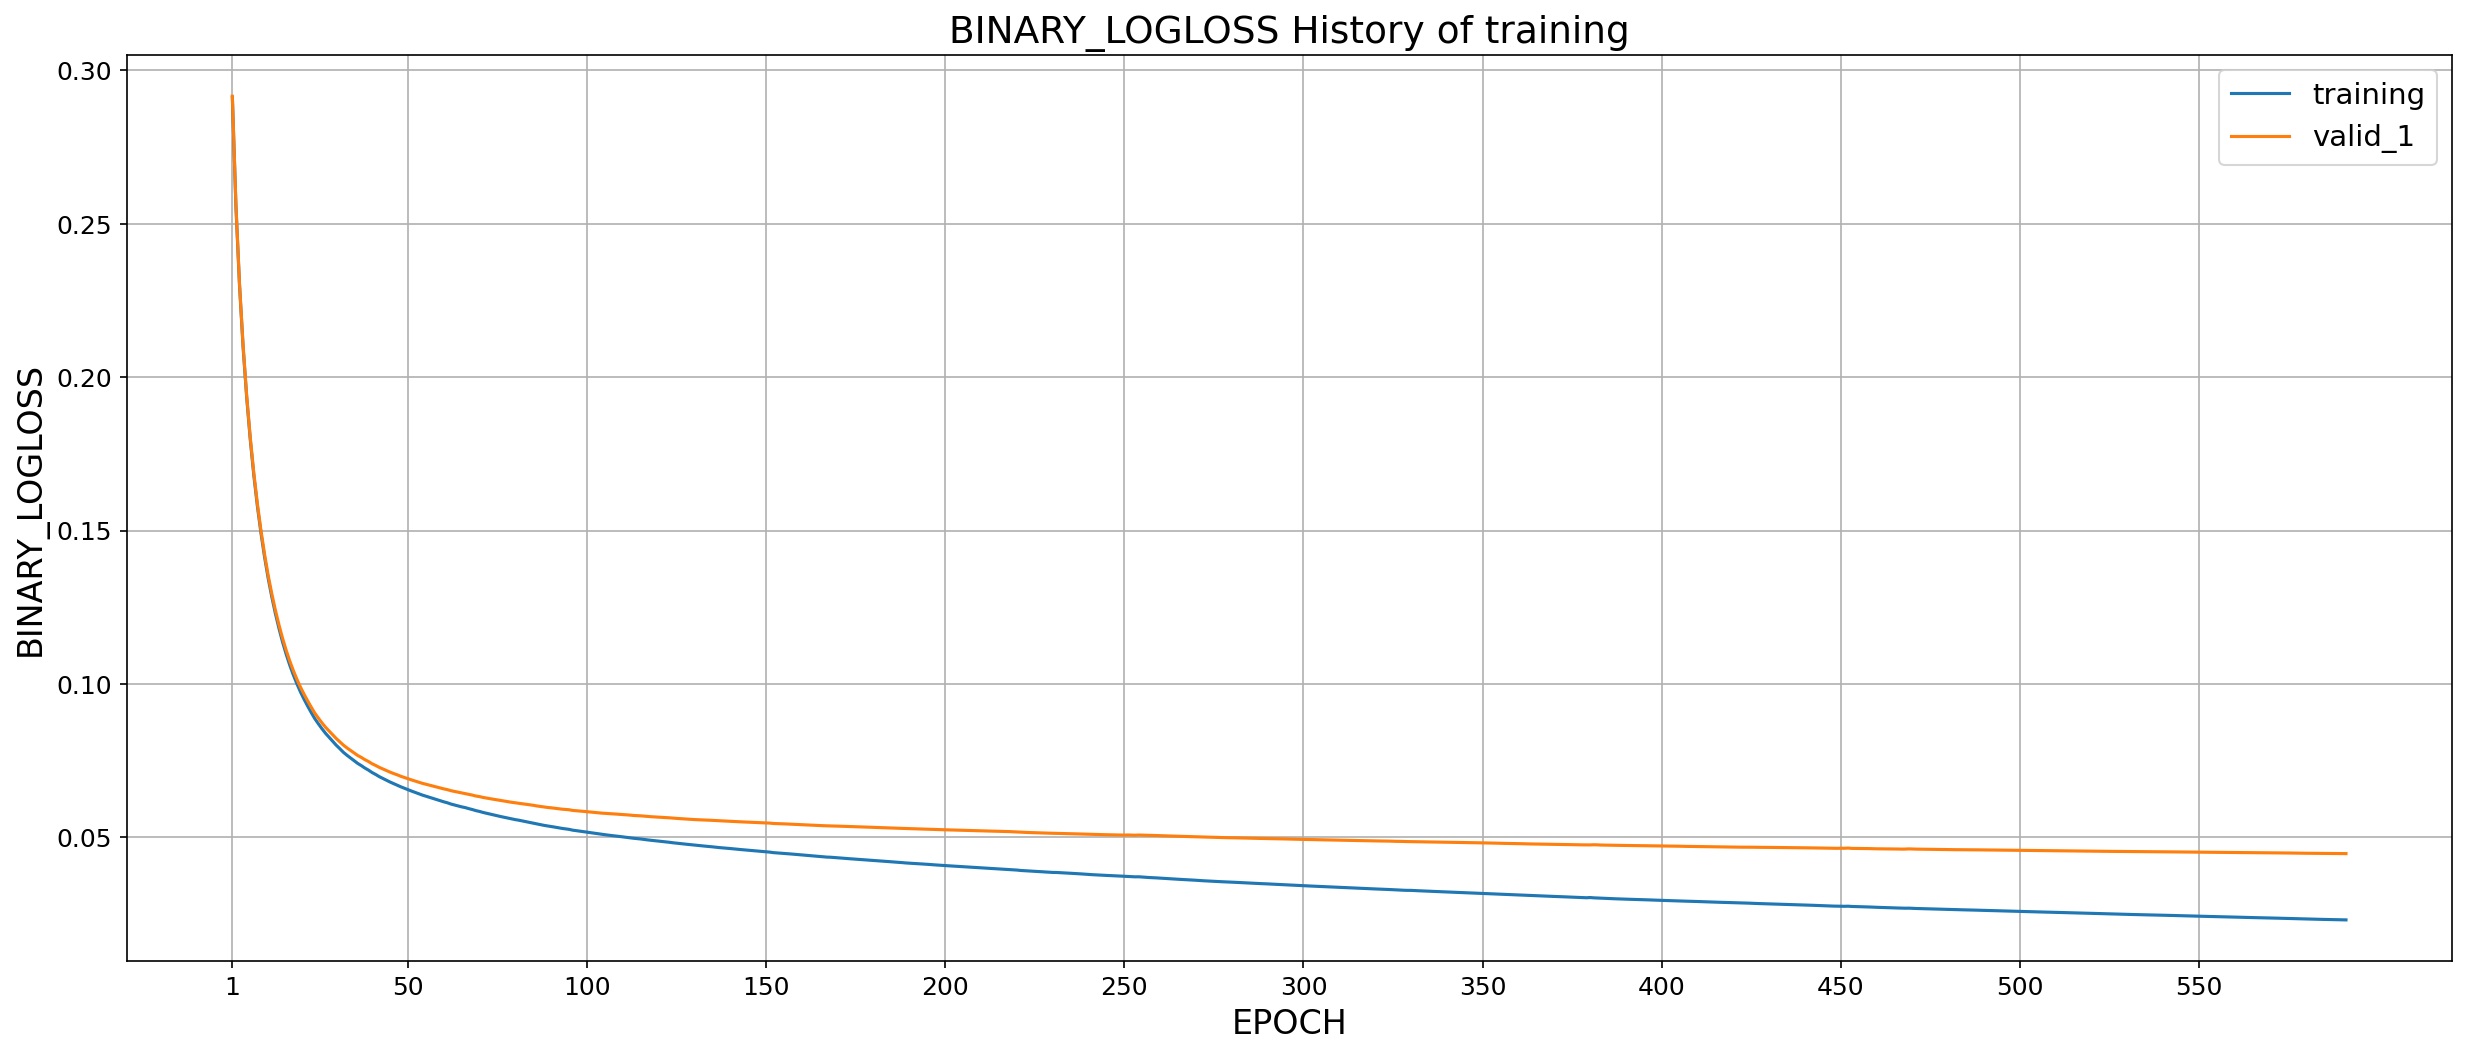

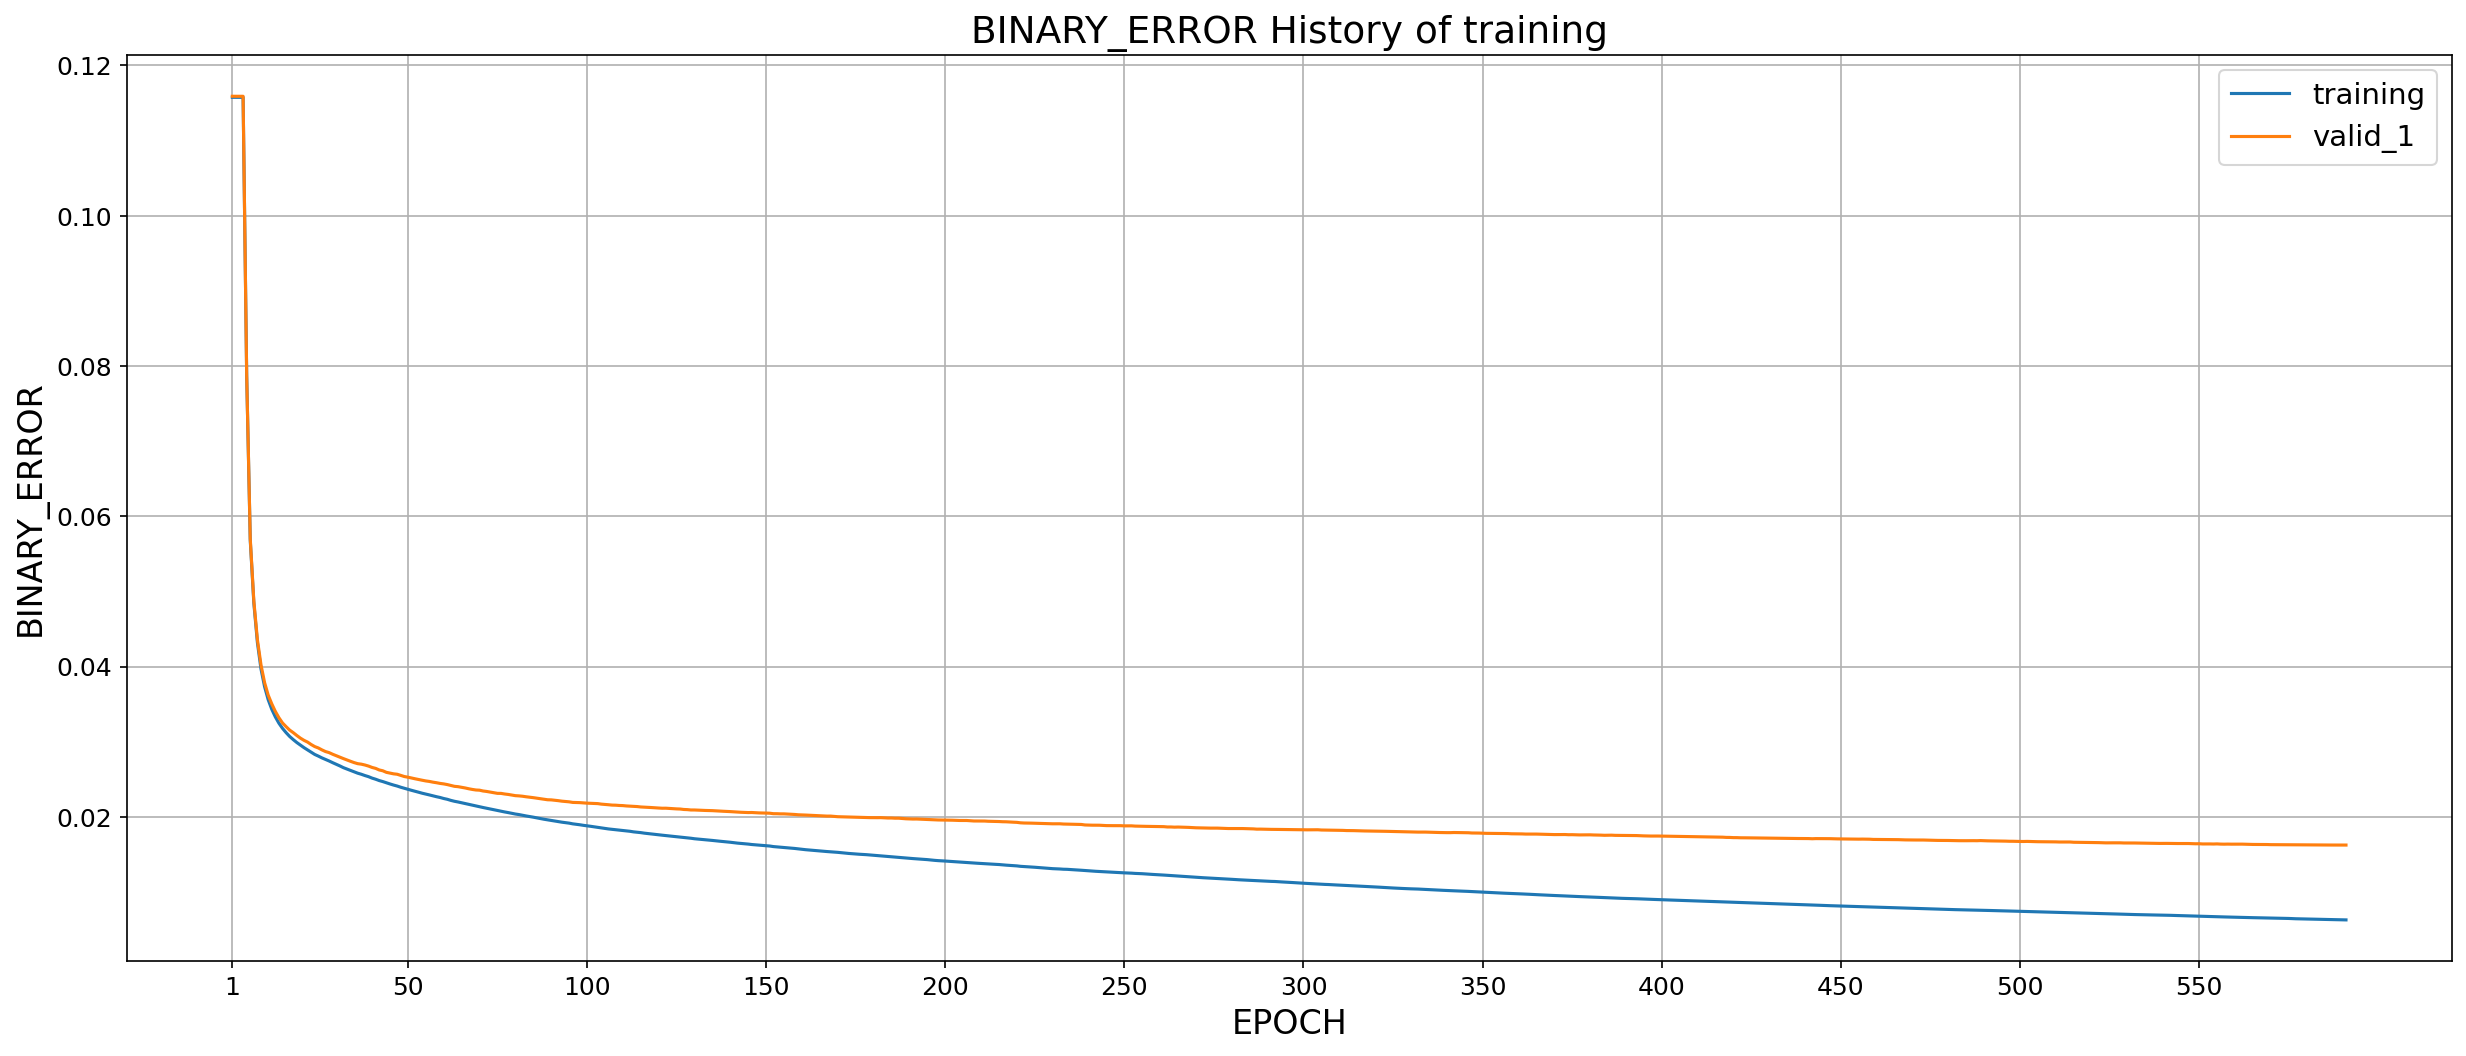

In [57]:
# plots the training history
def plot_history(evals_result):
    for metric in METRICS:
        plt.figure(figsize=(20,8))
        
        for key in evals_result.keys():
            history_len = len(evals_result.get(key)[metric])
            history = evals_result.get(key)[metric]
            x_axis = np.arange(1, history_len + 1)
            plt.plot(x_axis, history, label=key)
        
        x_ticks = list(filter(lambda e: (e % (history_len // 100 * 10) == 0) or e == 1, x_axis))
        plt.xticks(x_ticks, fontsize=12)
        plt.yticks(fontsize=12)

        plt.title(f'{metric.upper()} History of training', fontsize=18);
        plt.xlabel('EPOCH', fontsize=16)
        plt.ylabel(metric.upper(), fontsize=16)
        
        if metric in ['auc']:
            plt.legend(loc='upper left', fontsize=14)
        else:
            plt.legend(loc='upper right', fontsize=14)
        plt.grid()
        plt.show()

plot_history(evals_result)

# Feature Importance

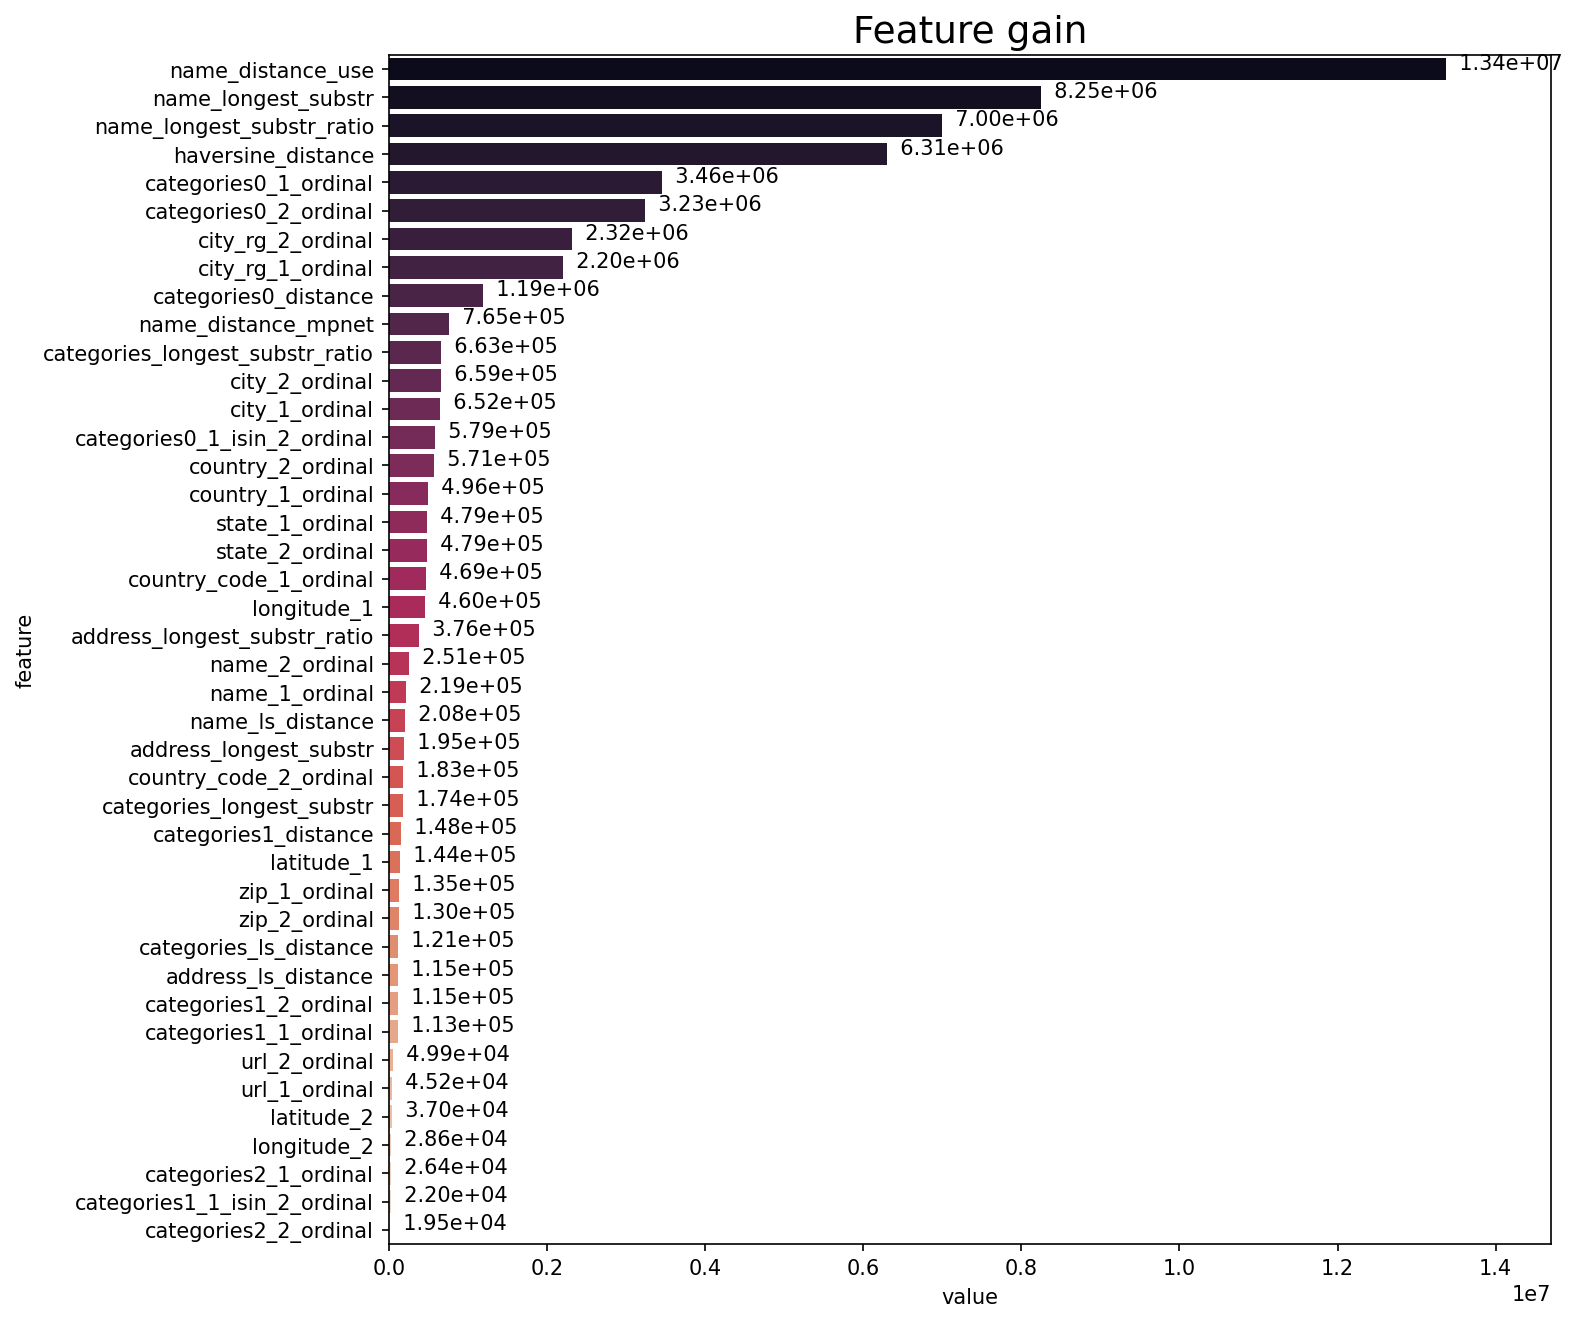

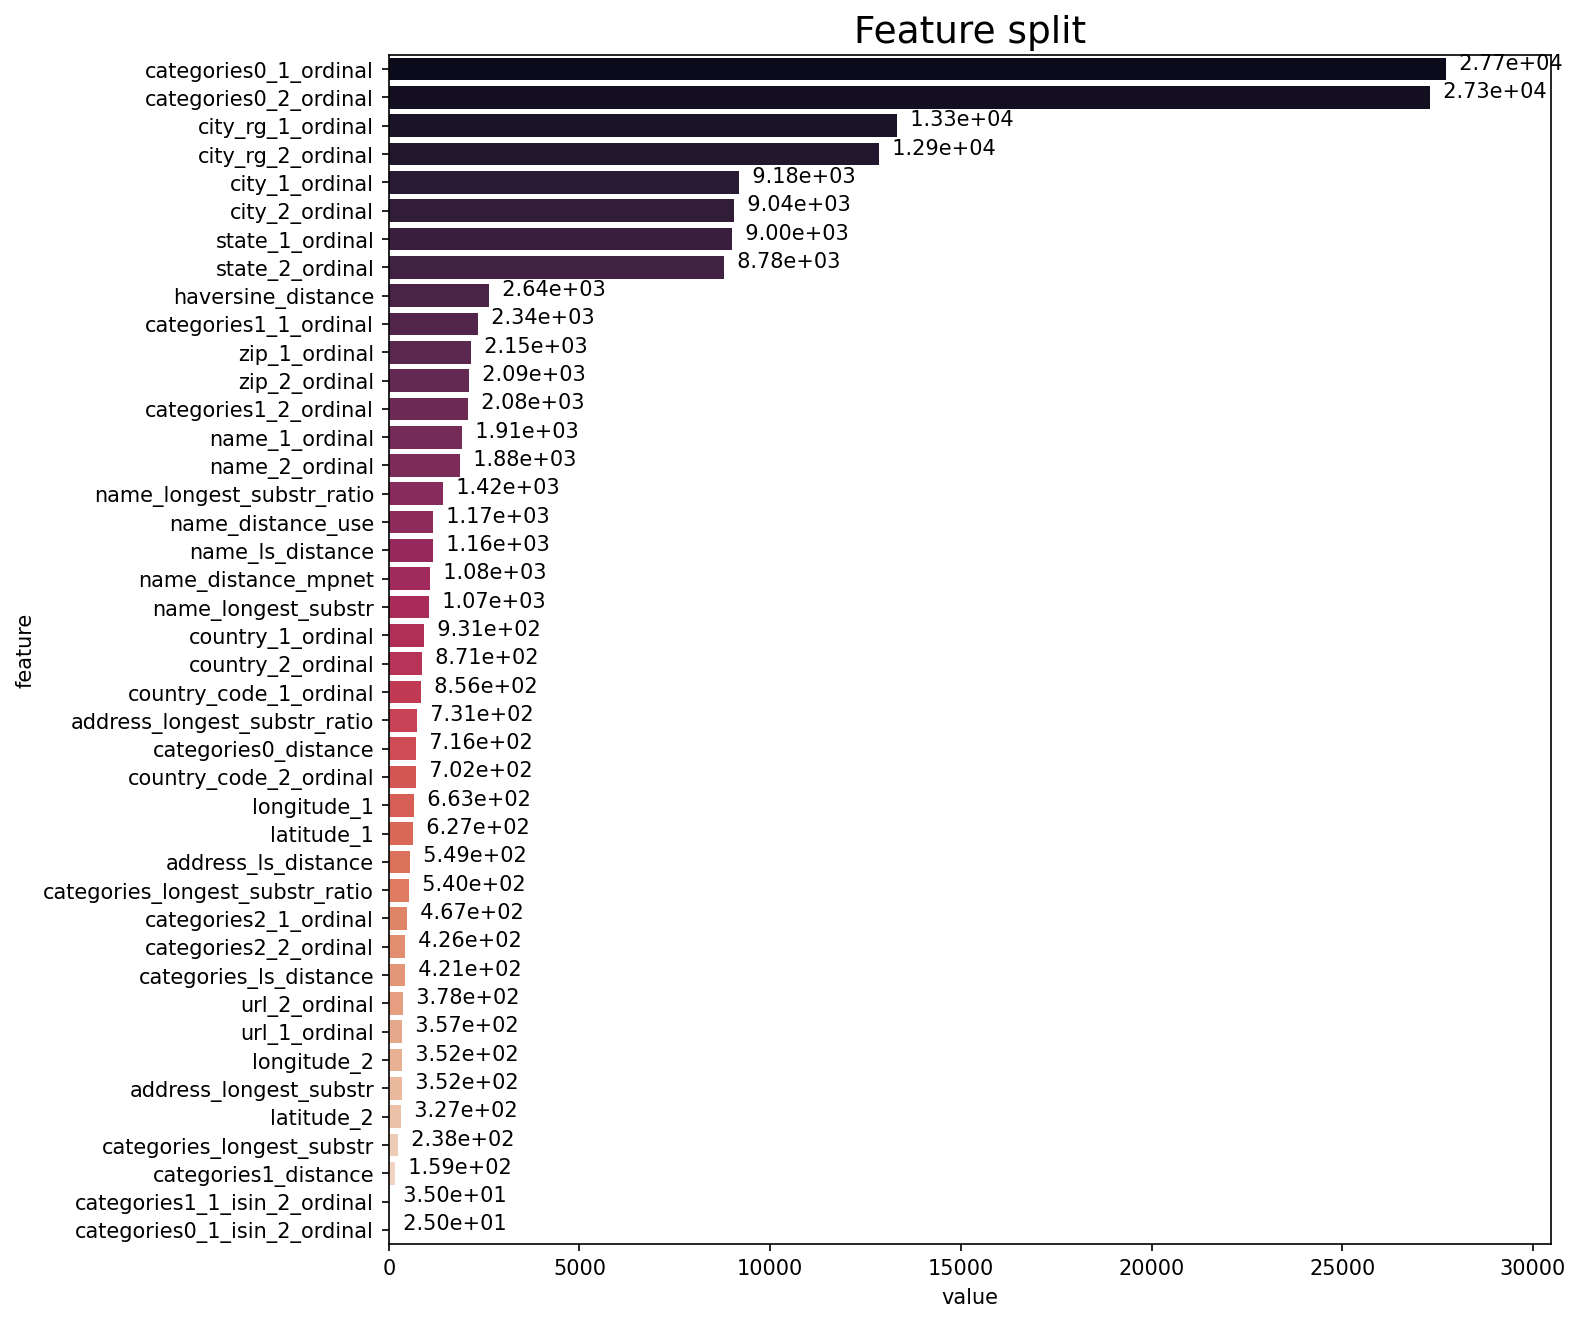

In [58]:
# This is incredibly important to see the performance of features
# If a feature is not used to split and does not provide much gain, remove it!
def show_feature_importances(model, importance_type, max_num_features=10**10):
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = features
    feature_importances['value'] = pd.DataFrame(model.feature_importance(importance_type))
    feature_importances = feature_importances.sort_values(by='value', ascending=False) # sort feature importance
    feature_importances.to_csv(f'feature_importances_{importance_type}.csv') # write feature importance to csv
    feature_importances = feature_importances[:max_num_features] # only show max_num_features
    
    plt.figure(figsize=(10, len(features) * 0.25))
    plt.xlim([0, feature_importances.value.max()*1.1])
    plt.title(f'Feature {importance_type}', fontsize=18);
    sns.barplot(data=feature_importances, x='value', y='feature', palette='rocket');
    for idx, v in enumerate(feature_importances.value):
        plt.text(v, idx, "  {:.2e}".format(v))

show_feature_importances(model_lgb, 'gain')
show_feature_importances(model_lgb, 'split')

# Precision/Recall/F1

In [59]:
# Predictions and true labels of validation dataset
y = pairs_target[val_idxs]
y_pred = model_lgb.predict(pairs_features[val_idxs])
print(f'y shape: {y.shape}, y_pred shape: {y_pred.shape}')

y shape: (821084,), y_pred shape: (821084,)


In [60]:
precision, recall, thresholds = metrics.precision_recall_curve(y, y_pred)
thresholds = np.concatenate(([0], thresholds))

f1 = 2 * (precision * recall) / (precision + recall)
f1_arg_best = np.argmax(f1)
f1_best_threshold = thresholds[f1_arg_best]
f1_best_value = f1.max()
print(f'Best F1({f1_best_value:.3f}) at Threshold {f1_best_threshold:.3f}')

Best F1(0.929) at Threshold 0.458


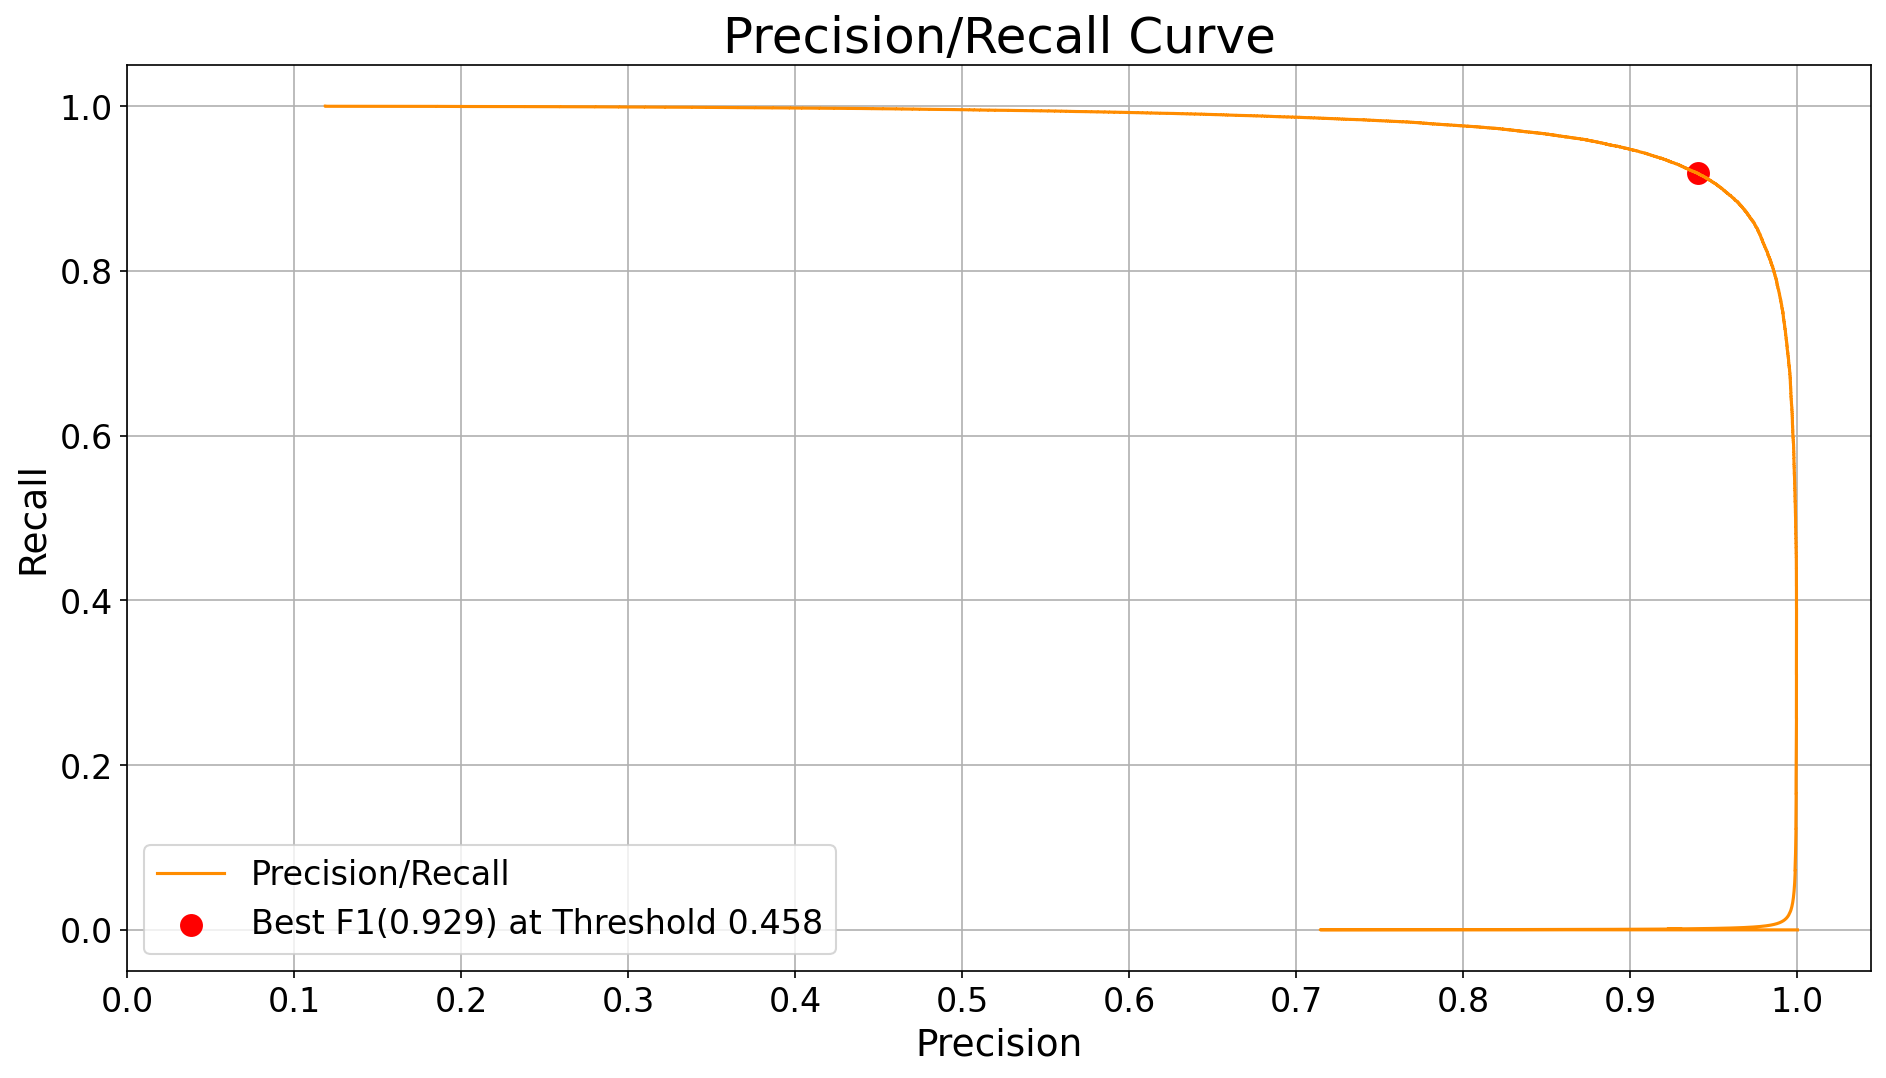

In [61]:
plt.figure(figsize=(15,8))
plt.plot(precision, recall, color='darkorange', label='Precision/Recall')
plt.scatter(precision[f1_arg_best], recall[f1_arg_best], color='red', s=100, marker='o', label=f'Best F1({f1_best_value:.3f}) at Threshold {f1_best_threshold:.3f}')
plt.title('Precision/Recall Curve', size=24)
plt.xlabel('Precision', size=18)
plt.ylabel('Recall', size=18)
plt.xticks(np.arange(0, 1.1, 0.1), size=16)
plt.yticks(size=16)
plt.grid()
plt.legend(prop={'size': 16})
plt.show()

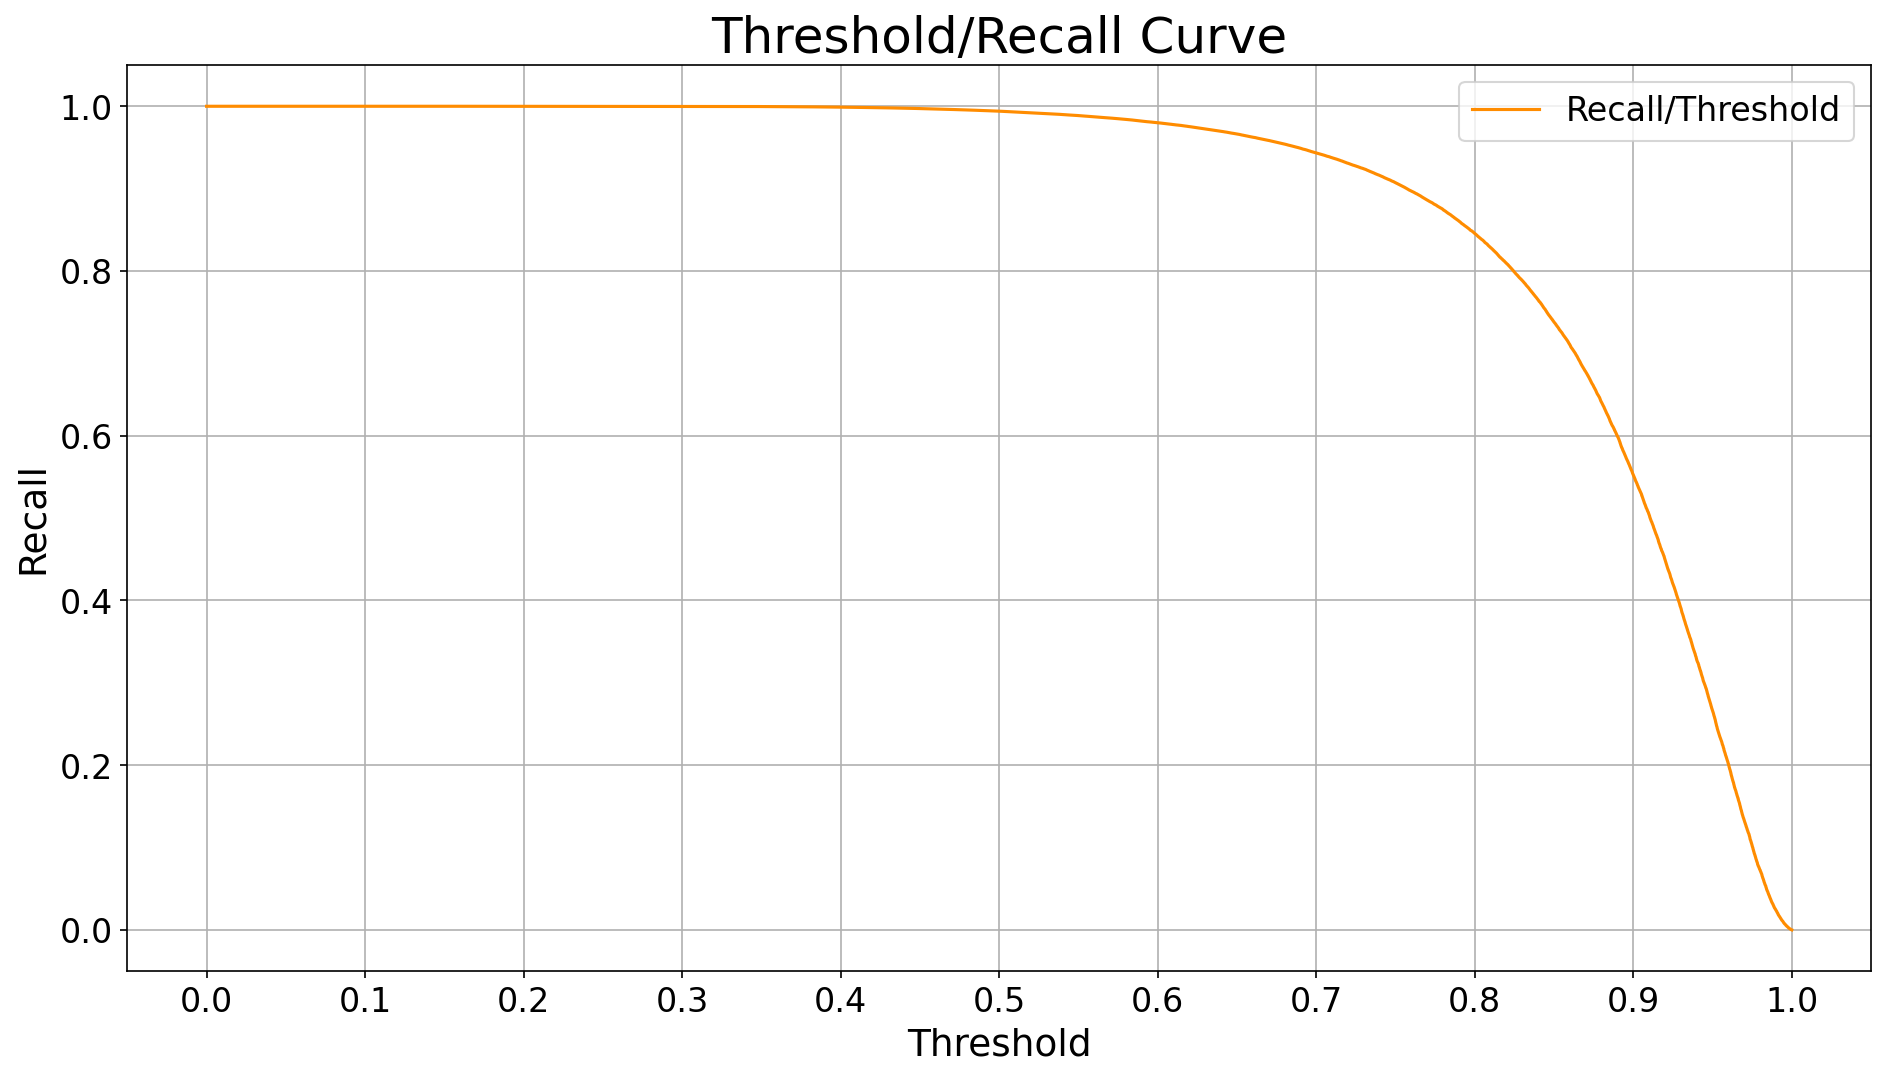

In [62]:
plt.figure(figsize=(15,8))
plt.plot(recall, thresholds,  color='darkorange', label='Recall/Threshold')
plt.title('Threshold/Recall Curve', size=24)
plt.xlabel('Threshold', size=18)
plt.ylabel('Recall', size=18)
plt.xticks(np.arange(0, 1.1, 0.1), size=16)
plt.yticks(size=16)
plt.grid()
plt.legend(prop={'size': 16})
plt.show()

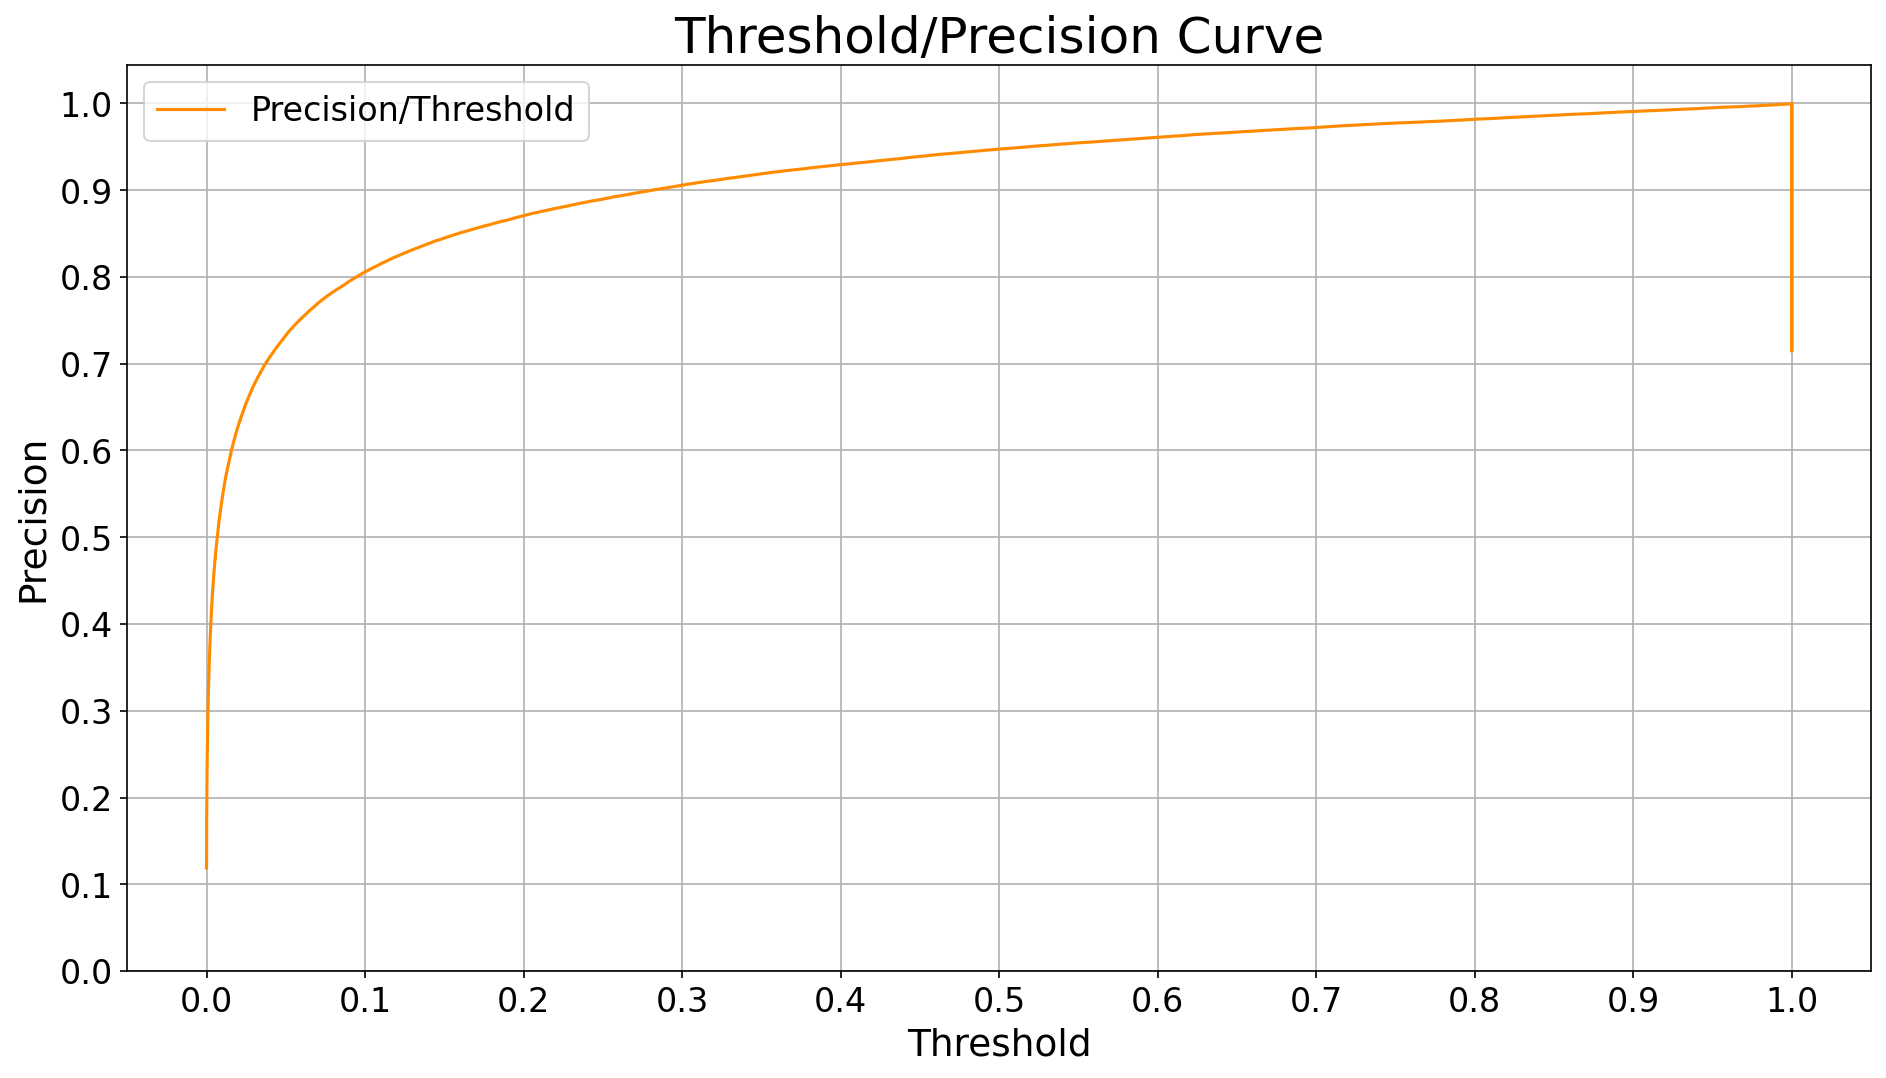

In [63]:
plt.figure(figsize=(15,8))
plt.plot(thresholds, precision,  color='darkorange', label='Precision/Threshold')
plt.title('Threshold/Precision Curve', size=24)
plt.xlabel('Threshold', size=18)
plt.ylabel('Precision', size=18)
plt.xticks(np.arange(0, 1.1, 0.1), size=16)
plt.yticks(np.arange(0, 1.1, 0.1), size=16)
plt.grid()
plt.legend(prop={'size': 16})
plt.show()

In [64]:
del pairs_features, pairs_target
gc.collect()

45587

# Inference

In [65]:
# Let's check how the submission should look like
display(sample_submission)

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98


In [66]:
# Deduce city and country by coordinates
test['city_rg'] = get_cities(test[['latitude', 'longitude']])
test['country_code'] = get_country_codes(test[['latitude', 'longitude']])

# Make pairs from the test set by simply concatenating the test set with postfix "_1"/"_2"
test_features = pd.concat([test.add_suffix('_1'), test.add_suffix('_2')], axis=1)
add_stand_alone_features(test_features)

display(test_features.head())

===== Ordinal Features =====


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,phone_1,categories_1,city_rg_1,country_code_1,id_2,name_2,latitude_2,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,city_rg_2,country_code_2,name_1_ordinal,name_2_ordinal,state_1_ordinal,state_2_ordinal,country_1_ordinal,country_2_ordinal,country_code_1_ordinal,country_code_2_ordinal,city_1_ordinal,city_2_ordinal,city_rg_1_ordinal,city_rg_2_ordinal,address_1_ordinal,address_2_ordinal,zip_1_ordinal,zip_2_ordinal,url_1_ordinal,url_2_ordinal,categories0_1_ordinal,categories0_2_ordinal,categories1_1_ordinal,categories1_2_ordinal,categories2_1_ordinal,categories2_2_ordinal
0,E_00001118ad0191,jamu petani bagan serai,5.012169,100.535805,,,,,my,,,cafés,Bagan Serai,MY,E_00001118ad0191,jamu petani bagan serai,5.012169,100.535805,,,,,my,,,cafés,Bagan Serai,MY,0,0,2,2,141,141,137,137,2,2,1,1,2,2,2,2,2,2,136,136,0,0,0,0
1,E_000020eb6fed40,johnny's bar,40.434208,-80.564163,497 n 12th st,weirton,wv,26062,us,,,bars,Weirton,US,E_000020eb6fed40,johnny's bar,40.434208,-80.564163,497 n 12th st,weirton,wv,26062,us,,,bars,Weirton,US,0,0,1643,1643,205,205,202,202,1,1,1,1,0,0,1,1,2,2,66,66,0,0,0,0
2,E_00002f98667edf,qiwi,47.215134,39.686089,"межевая улица, 60",ростов-на-дону,,,ru,https://qiwi.com,+78003011131,atms,Rostov-na-Donu,RU,E_00002f98667edf,qiwi,47.215134,39.686089,"межевая улица, 60",ростов-на-дону,,,ru,https://qiwi.com,+78003011131,atms,Rostov-na-Donu,RU,1,1,2,2,169,169,165,165,1806,1806,741,741,0,0,2,2,1,1,45,45,0,0,0,0
3,E_001b6bad66eb98,"gelora sriwijaya, jaka baring sport city",-3.014675,104.794373,,,,,id,,,stadiums,Sungaigerong,ID,E_001b6bad66eb98,"gelora sriwijaya, jaka baring sport city",-3.014675,104.794373,,,,,id,,,stadiums,Sungaigerong,ID,1,1,2,2,92,92,87,87,2,2,852,852,2,2,2,2,2,2,776,776,0,0,0,0
4,E_0283d9f61e569d,stadion gelora sriwijaya,-3.021727,104.788628,jalan gubernur hasan bastari,palembang,south sumatra,11480.0,id,,,soccer stadiums,Sungaigerong,ID,E_0283d9f61e569d,stadion gelora sriwijaya,-3.021727,104.788628,jalan gubernur hasan bastari,palembang,south sumatra,11480.0,id,,,soccer stadiums,Sungaigerong,ID,1,1,1403,1403,92,92,87,87,1205,1205,852,852,1,1,0,0,2,2,751,751,0,0,0,0


In [67]:
# The famous nearest neighbours lookup tree
tree = BallTree(np.deg2rad(test[['latitude', 'longitude']].values), metric='haversine')

In [68]:
# Columns to include, because they are needed to compute other features
support_columns_1 = ['name_1', 'address_1', 'categories_1']
support_columns_2 = ['name_2', 'address_2', 'categories_2']

In [69]:
test_features_np_1 = test_features[features_1 + support_columns_1].values.reshape([len(test_features), 1, -1])
test_features_np_2 = test_features[features_2 + support_columns_2].values

In [70]:
# Check for submission
IS_DUMMY_TEST = len(test) == 5
# Only the 15 nearest neighbours are used
N_NEIGHBOURS = 3 if IS_DUMMY_TEST else 15
# Threshold to include a point as match
THRESHOLD = 0.50
# Maximum distance to include neighbours from
MAX_DISTANCE_KM = 10
# Matrices to save features in, prediction will be done in 1 go
QUERY_MATRIX = np.zeros(shape=[len(test) * N_NEIGHBOURS, len(features)], dtype=np.float32)
QUERY_DISTANCES = np.zeros(shape=[len(test), N_NEIGHBOURS], dtype=np.float32)
QUERY_INDICES = np.zeros(shape=[len(test), N_NEIGHBOURS], dtype=np.int32)

# Inference loop
for row_idx, row in tqdm(test.iterrows(), total=len(test)):
    # Get 15 neaarest neighbours
    dist, ind = tree.query(np.deg2rad([row['latitude'], row['longitude']]).reshape(1, -1), k=N_NEIGHBOURS)
    # Distance from degrees to KM
    dist = dist.squeeze() * EARTH_RADIUS
    ind = ind.squeeze()

    # Make pairs dataframe
    df_query = pd.DataFrame(
        np.concatenate([
                np.repeat(test_features_np_1[row_idx], N_NEIGHBOURS, 0),
                test_features_np_2[ind]
            ]
        , axis=1)
    , columns=features_1 + support_columns_1 + features_2 + support_columns_2)
    
    # Add Combined Features
    add_combined_features(df_query)

    # Save query, distances and indices
    QUERY_MATRIX[row_idx * N_NEIGHBOURS:(row_idx + 1) * N_NEIGHBOURS] = df_query[features].values
    QUERY_DISTANCES[row_idx] = dist
    QUERY_INDICES[row_idx] = ind

  0%|          | 0/5 [00:00<?, ?it/s]

# Predictions

In [71]:
# Make a single model call, super efficient!
QUERY_PREDS = model_lgb.predict(QUERY_MATRIX).reshape([len(test), N_NEIGHBOURS])
QUERY_PREDS_SERIES = pd.Series(QUERY_PREDS.flatten())

In [72]:
display(QUERY_PREDS_SERIES.describe())

count    15.000000
mean      0.929918
std       0.195452
min       0.227580
25%       0.952695
50%       0.989778
75%       0.997711
max       0.999909
dtype: float64

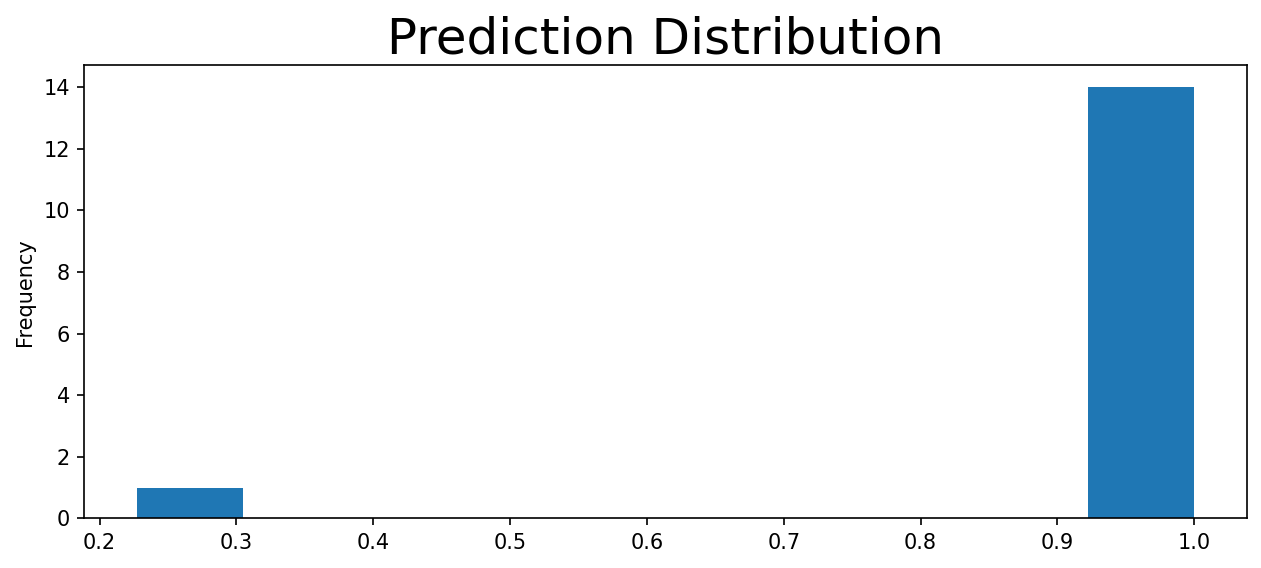

In [73]:
plt.figure(figsize=(10,4))
plt.title('Prediction Distribution', size=24)
QUERY_PREDS_SERIES.plot(kind='hist')
plt.show()

# Generate Submission DataFrame

In [74]:
# Rows of the DataFrame are saved as dictionaries
submission_dict = []

for row_idx, row in tqdm(test.iterrows(), total=len(test)):
    ind = QUERY_INDICES[row_idx]
    dist = QUERY_DISTANCES[row_idx]
    pred = QUERY_PREDS[row_idx]
    # Point is included if (mind the brackets):
    # (the confidence is above the threshold or the point refers to itself) and the distance is below the threshold
    pred_id_idxs = ind[((pred > THRESHOLD) | (ind == row_idx)) & (dist < MAX_DISTANCE_KM)]
    pred_ids = ' '.join(test.loc[pred_id_idxs, 'id'].tolist())
    
    submission_dict.append({
        'id': row['id'],
        'matches': pred_ids,
    })

  0%|          | 0/5 [00:00<?, ?it/s]

# Submission

In [75]:
pd.options.display.max_colwidth = 200
submission_df = pd.DataFrame(submission_dict)
display(submission_df.head())

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98


In [76]:
submission_df.to_csv('submission.csv', index=False)